# Deep Convolutional GAN

 Implementation and training of DCGAN (https://arxiv.org/abs/1511.06434) using CIFAR-10 dataset

### Setup

In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None, h=None, resize=False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x


def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx)
                          if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./DCGAN'):
    os.makedirs('./DCGAN')

cuda:0


### Data loading

In [11]:
batch_size = 128  
NUM_TRAIN = 49000

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


data_dir = './datasets'

cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                                 transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                               transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True,
                                transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Hyper-parameter selection

In [12]:
num_epochs = 20
learning_rate = 0.0002
latent_vector_size = 100
num_channels = 3

### Model definition

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.generate = nn.Sequential(
            # input is latent space vector
            nn.ConvTranspose2d(latent_vector_size, 64 * \
                               8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.1, inplace=True),
            # state size. (64*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.1, inplace=True),
            # state size. (64*4) x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.1, inplace=True),
            # state size. (64*2) x 16 x 16
            nn.ConvTranspose2d(64 * 2, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (3) x 32 x 32

        )

    def decode(self, z):
        x = self.generate(z)
        return x

    def forward(self, z):

        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminate = nn.Sequential(
            # Input is 32x32x3 colour image
            nn.Conv2d(num_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64) x 16 x 16
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*2) x 8 x 8
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*4) x 4 x 4
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*8) x 2 x 2
            nn.Conv2d(64 * 8, 1, 4, 1, 1, bias=False),
            nn.Sigmoid()
        )

    def discriminator(self, x):

        out = self.discriminate(x)

        return out

    def forward(self, x):
        outs = self.discriminator(x)
        return outs.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters

In [14]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [15]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 3448576
Generator(
  (generate): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


Total number of parameters in Discriminator is: 2765568
Discriminator(
  (discrimin

### Define loss function

In [16]:
criterion = nn.BCELoss(reduction='mean')


def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Initialize optimizers

In [17]:
# setup optimizer
beta1 = 0.5
optimizerD = torch.optim.Adam(
    model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, 1)

optimizerG = torch.optim.Adam(
    model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, 1)

### Define fixed input vectors to monitor training and mode collapse.

In [18]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [19]:
train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    for i, data in enumerate(loader_train, 0):
        train_loss_D = 0
        train_loss_G = 0

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size,
                            1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()
#         schedulerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()
#         schedulerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(loader_train),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(),
                   './DCGAN/real_samples.png')

    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()).float(),
               './DCGAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))

# save losses and models
torch.save(model_G.state_dict(), './DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './DCGAN/DCGAN_model_D.pth')

[0/20][0/383] Loss_D: 1.4195 Loss_G: 2.3097 D(x): 0.5134 D(G(z)): 0.5038 / 0.1071
[0/20][1/383] Loss_D: 1.2470 Loss_G: 2.2496 D(x): 0.5999 D(G(z)): 0.4817 / 0.1161
[0/20][2/383] Loss_D: 1.4333 Loss_G: 2.2592 D(x): 0.5499 D(G(z)): 0.5145 / 0.1167
[0/20][3/383] Loss_D: 1.2711 Loss_G: 2.7644 D(x): 0.5700 D(G(z)): 0.4473 / 0.0686
[0/20][4/383] Loss_D: 1.1379 Loss_G: 2.5778 D(x): 0.5245 D(G(z)): 0.3308 / 0.0824
[0/20][5/383] Loss_D: 0.9113 Loss_G: 3.3813 D(x): 0.7009 D(G(z)): 0.3894 / 0.0393
[0/20][6/383] Loss_D: 0.6982 Loss_G: 4.1098 D(x): 0.7539 D(G(z)): 0.3177 / 0.0198
[0/20][7/383] Loss_D: 0.7225 Loss_G: 4.1218 D(x): 0.7042 D(G(z)): 0.2816 / 0.0201
[0/20][8/383] Loss_D: 0.7769 Loss_G: 4.4523 D(x): 0.7217 D(G(z)): 0.3296 / 0.0142
[0/20][9/383] Loss_D: 0.7483 Loss_G: 4.5868 D(x): 0.6908 D(G(z)): 0.2739 / 0.0132
[0/20][10/383] Loss_D: 0.6889 Loss_G: 5.0318 D(x): 0.7500 D(G(z)): 0.2982 / 0.0085
[0/20][11/383] Loss_D: 0.5920 Loss_G: 4.7777 D(x): 0.7053 D(G(z)): 0.1767 / 0.0112
[0/20][12/383]

[0/20][100/383] Loss_D: 0.4100 Loss_G: 4.7171 D(x): 0.7289 D(G(z)): 0.0510 / 0.0108
[0/20][101/383] Loss_D: 0.3901 Loss_G: 3.6692 D(x): 0.8100 D(G(z)): 0.1278 / 0.0336
[0/20][102/383] Loss_D: 0.6864 Loss_G: 6.2021 D(x): 0.8672 D(G(z)): 0.3818 / 0.0027
[0/20][103/383] Loss_D: 0.4420 Loss_G: 5.3402 D(x): 0.6902 D(G(z)): 0.0243 / 0.0084
[0/20][104/383] Loss_D: 0.3252 Loss_G: 3.4310 D(x): 0.8111 D(G(z)): 0.0834 / 0.0446
[0/20][105/383] Loss_D: 0.7033 Loss_G: 6.0526 D(x): 0.9034 D(G(z)): 0.4099 / 0.0031
[0/20][106/383] Loss_D: 0.4317 Loss_G: 5.3149 D(x): 0.7086 D(G(z)): 0.0213 / 0.0071
[0/20][107/383] Loss_D: 0.4103 Loss_G: 3.3513 D(x): 0.7524 D(G(z)): 0.0657 / 0.0435
[0/20][108/383] Loss_D: 0.6691 Loss_G: 5.2419 D(x): 0.9239 D(G(z)): 0.4048 / 0.0096
[0/20][109/383] Loss_D: 0.3075 Loss_G: 4.9190 D(x): 0.8264 D(G(z)): 0.0797 / 0.0098
[0/20][110/383] Loss_D: 0.3856 Loss_G: 4.0462 D(x): 0.7813 D(G(z)): 0.0993 / 0.0217
[0/20][111/383] Loss_D: 0.5909 Loss_G: 6.5467 D(x): 0.8484 D(G(z)): 0.3135 /

[0/20][198/383] Loss_D: 0.5340 Loss_G: 2.8986 D(x): 0.6985 D(G(z)): 0.1215 / 0.0773
[0/20][199/383] Loss_D: 0.7547 Loss_G: 3.4018 D(x): 0.7995 D(G(z)): 0.3646 / 0.0447
[0/20][200/383] Loss_D: 0.5967 Loss_G: 2.9587 D(x): 0.7063 D(G(z)): 0.1722 / 0.0674
[0/20][201/383] Loss_D: 0.6361 Loss_G: 3.4828 D(x): 0.7846 D(G(z)): 0.2900 / 0.0390
[0/20][202/383] Loss_D: 0.6084 Loss_G: 2.4914 D(x): 0.6758 D(G(z)): 0.1469 / 0.0977
[0/20][203/383] Loss_D: 0.6370 Loss_G: 4.3979 D(x): 0.8794 D(G(z)): 0.3752 / 0.0169
[0/20][204/383] Loss_D: 0.4448 Loss_G: 3.1414 D(x): 0.7168 D(G(z)): 0.0677 / 0.0567
[0/20][205/383] Loss_D: 0.5905 Loss_G: 3.8115 D(x): 0.8000 D(G(z)): 0.2774 / 0.0284
[0/20][206/383] Loss_D: 0.4419 Loss_G: 2.2769 D(x): 0.7629 D(G(z)): 0.1221 / 0.1267
[0/20][207/383] Loss_D: 1.2973 Loss_G: 4.4058 D(x): 0.8885 D(G(z)): 0.6582 / 0.0162
[0/20][208/383] Loss_D: 1.0954 Loss_G: 0.2695 D(x): 0.4450 D(G(z)): 0.0971 / 0.7944
[0/20][209/383] Loss_D: 2.7021 Loss_G: 3.4693 D(x): 0.9274 D(G(z)): 0.8700 /

[0/20][296/383] Loss_D: 0.4869 Loss_G: 2.8153 D(x): 0.7653 D(G(z)): 0.1685 / 0.0744
[0/20][297/383] Loss_D: 0.5556 Loss_G: 3.3431 D(x): 0.8261 D(G(z)): 0.2785 / 0.0435
[0/20][298/383] Loss_D: 0.4995 Loss_G: 3.4736 D(x): 0.8004 D(G(z)): 0.2141 / 0.0420
[0/20][299/383] Loss_D: 0.7826 Loss_G: 2.4348 D(x): 0.6099 D(G(z)): 0.1875 / 0.1089
[0/20][300/383] Loss_D: 0.9480 Loss_G: 3.2724 D(x): 0.7111 D(G(z)): 0.4064 / 0.0460
[0/20][301/383] Loss_D: 0.6141 Loss_G: 3.0799 D(x): 0.7086 D(G(z)): 0.1894 / 0.0584
[0/20][302/383] Loss_D: 0.5792 Loss_G: 3.0193 D(x): 0.7634 D(G(z)): 0.2315 / 0.0627
[0/20][303/383] Loss_D: 0.5809 Loss_G: 3.5299 D(x): 0.7993 D(G(z)): 0.2689 / 0.0388
[0/20][304/383] Loss_D: 0.6791 Loss_G: 3.2894 D(x): 0.7151 D(G(z)): 0.2390 / 0.0466
[0/20][305/383] Loss_D: 0.6230 Loss_G: 3.2286 D(x): 0.7201 D(G(z)): 0.2112 / 0.0493
[0/20][306/383] Loss_D: 1.0102 Loss_G: 2.8609 D(x): 0.6099 D(G(z)): 0.3283 / 0.0729
[0/20][307/383] Loss_D: 0.6645 Loss_G: 3.8093 D(x): 0.7864 D(G(z)): 0.3025 /

[1/20][11/383] Loss_D: 0.7751 Loss_G: 3.4580 D(x): 0.6704 D(G(z)): 0.2646 / 0.0417
[1/20][12/383] Loss_D: 0.8929 Loss_G: 3.5697 D(x): 0.6451 D(G(z)): 0.3086 / 0.0426
[1/20][13/383] Loss_D: 0.8157 Loss_G: 3.1540 D(x): 0.6791 D(G(z)): 0.2870 / 0.0567
[1/20][14/383] Loss_D: 0.6168 Loss_G: 3.2140 D(x): 0.7403 D(G(z)): 0.2367 / 0.0517
[1/20][15/383] Loss_D: 0.7523 Loss_G: 4.0459 D(x): 0.7434 D(G(z)): 0.3112 / 0.0255
[1/20][16/383] Loss_D: 0.5696 Loss_G: 3.0401 D(x): 0.7020 D(G(z)): 0.1554 / 0.0685
[1/20][17/383] Loss_D: 0.5516 Loss_G: 3.5137 D(x): 0.7853 D(G(z)): 0.2424 / 0.0401
[1/20][18/383] Loss_D: 0.5538 Loss_G: 4.3720 D(x): 0.8361 D(G(z)): 0.2810 / 0.0182
[1/20][19/383] Loss_D: 0.4536 Loss_G: 3.2247 D(x): 0.7244 D(G(z)): 0.0916 / 0.0553
[1/20][20/383] Loss_D: 0.6163 Loss_G: 3.3122 D(x): 0.7926 D(G(z)): 0.2799 / 0.0535
[1/20][21/383] Loss_D: 0.5848 Loss_G: 4.2001 D(x): 0.8245 D(G(z)): 0.2837 / 0.0243
[1/20][22/383] Loss_D: 0.6390 Loss_G: 2.5071 D(x): 0.6457 D(G(z)): 0.1311 / 0.1019
[1/2

[1/20][111/383] Loss_D: 0.6842 Loss_G: 3.7245 D(x): 0.7516 D(G(z)): 0.2765 / 0.0332
[1/20][112/383] Loss_D: 0.5682 Loss_G: 2.7043 D(x): 0.7115 D(G(z)): 0.1575 / 0.0861
[1/20][113/383] Loss_D: 1.1680 Loss_G: 6.0860 D(x): 0.8166 D(G(z)): 0.5571 / 0.0038
[1/20][114/383] Loss_D: 1.1501 Loss_G: 2.5791 D(x): 0.4199 D(G(z)): 0.0276 / 0.1105
[1/20][115/383] Loss_D: 0.7862 Loss_G: 4.7509 D(x): 0.8952 D(G(z)): 0.4193 / 0.0154
[1/20][116/383] Loss_D: 0.4367 Loss_G: 3.6113 D(x): 0.7394 D(G(z)): 0.0750 / 0.0423
[1/20][117/383] Loss_D: 0.4463 Loss_G: 3.4684 D(x): 0.8556 D(G(z)): 0.2135 / 0.0439
[1/20][118/383] Loss_D: 0.4800 Loss_G: 3.9674 D(x): 0.8263 D(G(z)): 0.2123 / 0.0284
[1/20][119/383] Loss_D: 0.5594 Loss_G: 4.3398 D(x): 0.8163 D(G(z)): 0.2553 / 0.0176
[1/20][120/383] Loss_D: 0.6923 Loss_G: 3.0437 D(x): 0.6658 D(G(z)): 0.1622 / 0.0632
[1/20][121/383] Loss_D: 0.7166 Loss_G: 5.3034 D(x): 0.8361 D(G(z)): 0.3752 / 0.0067
[1/20][122/383] Loss_D: 0.7081 Loss_G: 2.9886 D(x): 0.5757 D(G(z)): 0.0421 /

[1/20][209/383] Loss_D: 0.5148 Loss_G: 3.0364 D(x): 0.7767 D(G(z)): 0.1843 / 0.0730
[1/20][210/383] Loss_D: 0.6179 Loss_G: 3.6023 D(x): 0.8057 D(G(z)): 0.2821 / 0.0424
[1/20][211/383] Loss_D: 0.5243 Loss_G: 3.7982 D(x): 0.8080 D(G(z)): 0.2242 / 0.0334
[1/20][212/383] Loss_D: 0.5195 Loss_G: 3.0362 D(x): 0.7470 D(G(z)): 0.1574 / 0.0697
[1/20][213/383] Loss_D: 0.5271 Loss_G: 3.2420 D(x): 0.8116 D(G(z)): 0.2264 / 0.0555
[1/20][214/383] Loss_D: 0.5715 Loss_G: 3.1632 D(x): 0.7565 D(G(z)): 0.2095 / 0.0584
[1/20][215/383] Loss_D: 0.5116 Loss_G: 4.2412 D(x): 0.8610 D(G(z)): 0.2604 / 0.0215
[1/20][216/383] Loss_D: 0.6363 Loss_G: 2.7387 D(x): 0.6580 D(G(z)): 0.1265 / 0.0958
[1/20][217/383] Loss_D: 0.5443 Loss_G: 4.0992 D(x): 0.9017 D(G(z)): 0.3113 / 0.0248
[1/20][218/383] Loss_D: 0.5245 Loss_G: 3.5568 D(x): 0.7568 D(G(z)): 0.1700 / 0.0419
[1/20][219/383] Loss_D: 0.4525 Loss_G: 3.1787 D(x): 0.7930 D(G(z)): 0.1478 / 0.0643
[1/20][220/383] Loss_D: 0.4627 Loss_G: 4.4037 D(x): 0.8816 D(G(z)): 0.2587 /

[1/20][307/383] Loss_D: 0.6459 Loss_G: 3.0568 D(x): 0.7682 D(G(z)): 0.2734 / 0.0637
[1/20][308/383] Loss_D: 0.6565 Loss_G: 3.3225 D(x): 0.7506 D(G(z)): 0.2609 / 0.0466
[1/20][309/383] Loss_D: 0.6204 Loss_G: 2.6776 D(x): 0.7088 D(G(z)): 0.1964 / 0.0916
[1/20][310/383] Loss_D: 0.6124 Loss_G: 3.6582 D(x): 0.8144 D(G(z)): 0.3003 / 0.0331
[1/20][311/383] Loss_D: 0.4894 Loss_G: 3.2145 D(x): 0.7631 D(G(z)): 0.1662 / 0.0509
[1/20][312/383] Loss_D: 0.6631 Loss_G: 2.0770 D(x): 0.6754 D(G(z)): 0.1913 / 0.1504
[1/20][313/383] Loss_D: 0.6648 Loss_G: 5.0649 D(x): 0.9126 D(G(z)): 0.3954 / 0.0093
[1/20][314/383] Loss_D: 0.5255 Loss_G: 3.4474 D(x): 0.6474 D(G(z)): 0.0246 / 0.0447
[1/20][315/383] Loss_D: 0.3554 Loss_G: 2.2569 D(x): 0.8378 D(G(z)): 0.1405 / 0.1305
[1/20][316/383] Loss_D: 0.6946 Loss_G: 4.8534 D(x): 0.9615 D(G(z)): 0.4449 / 0.0101
[1/20][317/383] Loss_D: 0.6268 Loss_G: 2.9720 D(x): 0.5939 D(G(z)): 0.0373 / 0.0658
[1/20][318/383] Loss_D: 0.3084 Loss_G: 2.4987 D(x): 0.8958 D(G(z)): 0.1701 /

[2/20][22/383] Loss_D: 0.5766 Loss_G: 2.7751 D(x): 0.7506 D(G(z)): 0.2115 / 0.0818
[2/20][23/383] Loss_D: 0.5301 Loss_G: 2.7909 D(x): 0.7788 D(G(z)): 0.2064 / 0.0801
[2/20][24/383] Loss_D: 0.6352 Loss_G: 3.4084 D(x): 0.7982 D(G(z)): 0.2901 / 0.0447
[2/20][25/383] Loss_D: 0.4740 Loss_G: 2.7256 D(x): 0.7398 D(G(z)): 0.1200 / 0.0831
[2/20][26/383] Loss_D: 0.4238 Loss_G: 3.3304 D(x): 0.8725 D(G(z)): 0.2295 / 0.0454
[2/20][27/383] Loss_D: 0.6167 Loss_G: 3.3189 D(x): 0.7906 D(G(z)): 0.2665 / 0.0504
[2/20][28/383] Loss_D: 0.7205 Loss_G: 2.4433 D(x): 0.6660 D(G(z)): 0.2013 / 0.1113
[2/20][29/383] Loss_D: 0.4787 Loss_G: 3.6440 D(x): 0.8520 D(G(z)): 0.2478 / 0.0342
[2/20][30/383] Loss_D: 0.5895 Loss_G: 3.5883 D(x): 0.7658 D(G(z)): 0.2277 / 0.0403
[2/20][31/383] Loss_D: 0.8408 Loss_G: 1.3759 D(x): 0.5817 D(G(z)): 0.1657 / 0.3047
[2/20][32/383] Loss_D: 1.0660 Loss_G: 5.5640 D(x): 0.8772 D(G(z)): 0.5610 / 0.0057
[2/20][33/383] Loss_D: 1.2497 Loss_G: 1.8048 D(x): 0.3604 D(G(z)): 0.0194 / 0.2121
[2/2

[2/20][122/383] Loss_D: 0.8034 Loss_G: 1.9615 D(x): 0.5979 D(G(z)): 0.1726 / 0.1780
[2/20][123/383] Loss_D: 1.0081 Loss_G: 2.4154 D(x): 0.6735 D(G(z)): 0.3807 / 0.1169
[2/20][124/383] Loss_D: 0.7616 Loss_G: 2.5681 D(x): 0.7096 D(G(z)): 0.2911 / 0.0972
[2/20][125/383] Loss_D: 0.7770 Loss_G: 2.7404 D(x): 0.7185 D(G(z)): 0.3200 / 0.0808
[2/20][126/383] Loss_D: 0.6588 Loss_G: 2.0480 D(x): 0.6879 D(G(z)): 0.1940 / 0.1575
[2/20][127/383] Loss_D: 0.9083 Loss_G: 3.7616 D(x): 0.7654 D(G(z)): 0.4299 / 0.0305
[2/20][128/383] Loss_D: 0.7461 Loss_G: 2.0915 D(x): 0.5917 D(G(z)): 0.1366 / 0.1577
[2/20][129/383] Loss_D: 0.8268 Loss_G: 2.6145 D(x): 0.7489 D(G(z)): 0.3643 / 0.0894
[2/20][130/383] Loss_D: 1.3224 Loss_G: 3.6425 D(x): 0.6170 D(G(z)): 0.4890 / 0.0377
[2/20][131/383] Loss_D: 0.9071 Loss_G: 1.4253 D(x): 0.5049 D(G(z)): 0.1064 / 0.2946
[2/20][132/383] Loss_D: 0.9163 Loss_G: 5.0491 D(x): 0.9640 D(G(z)): 0.5304 / 0.0105
[2/20][133/383] Loss_D: 0.6739 Loss_G: 3.2878 D(x): 0.5954 D(G(z)): 0.0395 /

[2/20][220/383] Loss_D: 0.6134 Loss_G: 3.3988 D(x): 0.8294 D(G(z)): 0.3135 / 0.0425
[2/20][221/383] Loss_D: 0.4285 Loss_G: 2.8665 D(x): 0.7599 D(G(z)): 0.1194 / 0.0710
[2/20][222/383] Loss_D: 0.5034 Loss_G: 2.9168 D(x): 0.8298 D(G(z)): 0.2469 / 0.0696
[2/20][223/383] Loss_D: 0.6442 Loss_G: 2.8071 D(x): 0.7395 D(G(z)): 0.2579 / 0.0741
[2/20][224/383] Loss_D: 0.7622 Loss_G: 2.2300 D(x): 0.6564 D(G(z)): 0.2384 / 0.1319
[2/20][225/383] Loss_D: 0.6321 Loss_G: 2.8741 D(x): 0.7655 D(G(z)): 0.2721 / 0.0706
[2/20][226/383] Loss_D: 0.5453 Loss_G: 3.5297 D(x): 0.8082 D(G(z)): 0.2555 / 0.0383
[2/20][227/383] Loss_D: 0.7091 Loss_G: 1.8546 D(x): 0.6237 D(G(z)): 0.1694 / 0.1838
[2/20][228/383] Loss_D: 0.6402 Loss_G: 3.7987 D(x): 0.8720 D(G(z)): 0.3689 / 0.0279
[2/20][229/383] Loss_D: 0.3882 Loss_G: 3.0507 D(x): 0.7583 D(G(z)): 0.0786 / 0.0629
[2/20][230/383] Loss_D: 0.4857 Loss_G: 3.0894 D(x): 0.8513 D(G(z)): 0.2550 / 0.0571
[2/20][231/383] Loss_D: 0.5290 Loss_G: 1.9674 D(x): 0.6842 D(G(z)): 0.1038 /

[2/20][318/383] Loss_D: 0.5694 Loss_G: 4.0785 D(x): 0.6240 D(G(z)): 0.0381 / 0.0241
[2/20][319/383] Loss_D: 0.3590 Loss_G: 2.2729 D(x): 0.7833 D(G(z)): 0.0859 / 0.1314
[2/20][320/383] Loss_D: 0.6350 Loss_G: 2.5532 D(x): 0.8068 D(G(z)): 0.3064 / 0.0978
[2/20][321/383] Loss_D: 0.5568 Loss_G: 2.8405 D(x): 0.7624 D(G(z)): 0.2207 / 0.0710
[2/20][322/383] Loss_D: 0.4986 Loss_G: 2.6755 D(x): 0.7584 D(G(z)): 0.1752 / 0.0852
[2/20][323/383] Loss_D: 0.4262 Loss_G: 3.3605 D(x): 0.8678 D(G(z)): 0.2305 / 0.0444
[2/20][324/383] Loss_D: 0.3937 Loss_G: 2.9648 D(x): 0.7905 D(G(z)): 0.1240 / 0.0641
[2/20][325/383] Loss_D: 0.4716 Loss_G: 2.7550 D(x): 0.8123 D(G(z)): 0.2080 / 0.0788
[2/20][326/383] Loss_D: 0.4669 Loss_G: 2.9644 D(x): 0.8247 D(G(z)): 0.2205 / 0.0622
[2/20][327/383] Loss_D: 0.5355 Loss_G: 3.6366 D(x): 0.8258 D(G(z)): 0.2679 / 0.0344
[2/20][328/383] Loss_D: 0.5814 Loss_G: 2.2777 D(x): 0.6659 D(G(z)): 0.1138 / 0.1227
[2/20][329/383] Loss_D: 0.6565 Loss_G: 3.7868 D(x): 0.8665 D(G(z)): 0.3728 /

[3/20][35/383] Loss_D: 0.6478 Loss_G: 3.7626 D(x): 0.6992 D(G(z)): 0.2067 / 0.0292
[3/20][36/383] Loss_D: 0.5066 Loss_G: 3.1727 D(x): 0.7280 D(G(z)): 0.1446 / 0.0518
[3/20][37/383] Loss_D: 0.3602 Loss_G: 4.3787 D(x): 0.9082 D(G(z)): 0.2172 / 0.0165
[3/20][38/383] Loss_D: 0.1529 Loss_G: 4.4912 D(x): 0.9138 D(G(z)): 0.0573 / 0.0145
[3/20][39/383] Loss_D: 0.1647 Loss_G: 3.7780 D(x): 0.9068 D(G(z)): 0.0598 / 0.0297
[3/20][40/383] Loss_D: 0.1952 Loss_G: 3.7317 D(x): 0.9512 D(G(z)): 0.1297 / 0.0310
[3/20][41/383] Loss_D: 0.3930 Loss_G: 4.1058 D(x): 0.8855 D(G(z)): 0.2202 / 0.0202
[3/20][42/383] Loss_D: 0.4043 Loss_G: 4.6220 D(x): 0.8803 D(G(z)): 0.2259 / 0.0132
[3/20][43/383] Loss_D: 0.6016 Loss_G: 2.4878 D(x): 0.6687 D(G(z)): 0.1361 / 0.1019
[3/20][44/383] Loss_D: 1.3435 Loss_G: 5.0524 D(x): 0.7261 D(G(z)): 0.5884 / 0.0092
[3/20][45/383] Loss_D: 0.8656 Loss_G: 2.5490 D(x): 0.4973 D(G(z)): 0.0675 / 0.1046
[3/20][46/383] Loss_D: 1.0442 Loss_G: 5.9677 D(x): 0.8926 D(G(z)): 0.5581 / 0.0036
[3/2

[3/20][135/383] Loss_D: 0.8357 Loss_G: 3.1927 D(x): 0.4769 D(G(z)): 0.0175 / 0.0507
[3/20][136/383] Loss_D: 0.2970 Loss_G: 2.5748 D(x): 0.9178 D(G(z)): 0.1809 / 0.0919
[3/20][137/383] Loss_D: 0.5332 Loss_G: 4.4987 D(x): 0.9065 D(G(z)): 0.3224 / 0.0152
[3/20][138/383] Loss_D: 0.5749 Loss_G: 2.6843 D(x): 0.6283 D(G(z)): 0.0461 / 0.0876
[3/20][139/383] Loss_D: 0.5103 Loss_G: 3.3114 D(x): 0.8921 D(G(z)): 0.3017 / 0.0460
[3/20][140/383] Loss_D: 0.4546 Loss_G: 3.3490 D(x): 0.7943 D(G(z)): 0.1729 / 0.0456
[3/20][141/383] Loss_D: 0.3665 Loss_G: 3.4619 D(x): 0.8482 D(G(z)): 0.1654 / 0.0405
[3/20][142/383] Loss_D: 0.4725 Loss_G: 2.3454 D(x): 0.7265 D(G(z)): 0.1114 / 0.1136
[3/20][143/383] Loss_D: 0.4955 Loss_G: 4.4147 D(x): 0.9335 D(G(z)): 0.3140 / 0.0180
[3/20][144/383] Loss_D: 0.4525 Loss_G: 3.0212 D(x): 0.7311 D(G(z)): 0.1047 / 0.0612
[3/20][145/383] Loss_D: 0.4603 Loss_G: 3.9064 D(x): 0.8820 D(G(z)): 0.2577 / 0.0262
[3/20][146/383] Loss_D: 0.5189 Loss_G: 2.6170 D(x): 0.6931 D(G(z)): 0.1056 /

[3/20][233/383] Loss_D: 0.6041 Loss_G: 2.3357 D(x): 0.6398 D(G(z)): 0.0994 / 0.1213
[3/20][234/383] Loss_D: 0.5736 Loss_G: 2.7775 D(x): 0.8129 D(G(z)): 0.2716 / 0.0782
[3/20][235/383] Loss_D: 0.6004 Loss_G: 3.5677 D(x): 0.7931 D(G(z)): 0.2753 / 0.0377
[3/20][236/383] Loss_D: 0.5510 Loss_G: 2.6052 D(x): 0.7133 D(G(z)): 0.1605 / 0.0929
[3/20][237/383] Loss_D: 0.4580 Loss_G: 3.0428 D(x): 0.8334 D(G(z)): 0.2190 / 0.0620
[3/20][238/383] Loss_D: 0.4151 Loss_G: 3.7949 D(x): 0.8636 D(G(z)): 0.2147 / 0.0291
[3/20][239/383] Loss_D: 0.5548 Loss_G: 2.4548 D(x): 0.6998 D(G(z)): 0.1513 / 0.1044
[3/20][240/383] Loss_D: 0.3523 Loss_G: 3.5150 D(x): 0.9059 D(G(z)): 0.2099 / 0.0375
[3/20][241/383] Loss_D: 0.4474 Loss_G: 2.5369 D(x): 0.7624 D(G(z)): 0.1313 / 0.0980
[3/20][242/383] Loss_D: 0.4781 Loss_G: 2.6740 D(x): 0.7924 D(G(z)): 0.1939 / 0.0879
[3/20][243/383] Loss_D: 0.6542 Loss_G: 3.3432 D(x): 0.7571 D(G(z)): 0.2806 / 0.0433
[3/20][244/383] Loss_D: 0.6376 Loss_G: 1.5795 D(x): 0.6418 D(G(z)): 0.1210 /

[3/20][331/383] Loss_D: 0.8815 Loss_G: 6.4808 D(x): 0.9380 D(G(z)): 0.5162 / 0.0023
[3/20][332/383] Loss_D: 1.2738 Loss_G: 1.6635 D(x): 0.3579 D(G(z)): 0.0175 / 0.2393
[3/20][333/383] Loss_D: 1.3868 Loss_G: 6.6895 D(x): 0.9444 D(G(z)): 0.6675 / 0.0023
[3/20][334/383] Loss_D: 1.2394 Loss_G: 2.1802 D(x): 0.3720 D(G(z)): 0.0127 / 0.1574
[3/20][335/383] Loss_D: 0.6592 Loss_G: 3.5413 D(x): 0.8925 D(G(z)): 0.3760 / 0.0417
[3/20][336/383] Loss_D: 0.4773 Loss_G: 4.4381 D(x): 0.8621 D(G(z)): 0.2494 / 0.0158
[3/20][337/383] Loss_D: 0.7808 Loss_G: 1.0831 D(x): 0.5584 D(G(z)): 0.0932 / 0.3901
[3/20][338/383] Loss_D: 1.8141 Loss_G: 6.1565 D(x): 0.9696 D(G(z)): 0.7837 / 0.0037
[3/20][339/383] Loss_D: 1.4902 Loss_G: 0.2930 D(x): 0.2885 D(G(z)): 0.0162 / 0.7653
[3/20][340/383] Loss_D: 2.4731 Loss_G: 7.7847 D(x): 0.9812 D(G(z)): 0.8755 / 0.0008
[3/20][341/383] Loss_D: 1.3519 Loss_G: 5.3718 D(x): 0.3197 D(G(z)): 0.0023 / 0.0079
[3/20][342/383] Loss_D: 1.2159 Loss_G: 0.4254 D(x): 0.4747 D(G(z)): 0.2651 /

[4/20][48/383] Loss_D: 0.7165 Loss_G: 3.0791 D(x): 0.7465 D(G(z)): 0.3066 / 0.0593
[4/20][49/383] Loss_D: 0.5828 Loss_G: 3.5218 D(x): 0.8009 D(G(z)): 0.2682 / 0.0369
[4/20][50/383] Loss_D: 0.6108 Loss_G: 2.3575 D(x): 0.6917 D(G(z)): 0.1714 / 0.1130
[4/20][51/383] Loss_D: 0.7707 Loss_G: 3.8486 D(x): 0.8334 D(G(z)): 0.4109 / 0.0273
[4/20][52/383] Loss_D: 0.7187 Loss_G: 2.2885 D(x): 0.6099 D(G(z)): 0.1468 / 0.1241
[4/20][53/383] Loss_D: 0.7550 Loss_G: 3.4053 D(x): 0.7996 D(G(z)): 0.3598 / 0.0481
[4/20][54/383] Loss_D: 0.5006 Loss_G: 3.4415 D(x): 0.7882 D(G(z)): 0.2028 / 0.0412
[4/20][55/383] Loss_D: 0.8186 Loss_G: 2.3792 D(x): 0.6234 D(G(z)): 0.2372 / 0.1196
[4/20][56/383] Loss_D: 0.3836 Loss_G: 3.1527 D(x): 0.8455 D(G(z)): 0.1675 / 0.0608
[4/20][57/383] Loss_D: 0.7017 Loss_G: 3.7409 D(x): 0.7861 D(G(z)): 0.3216 / 0.0344
[4/20][58/383] Loss_D: 0.6587 Loss_G: 3.2514 D(x): 0.7096 D(G(z)): 0.2110 / 0.0546
[4/20][59/383] Loss_D: 0.7715 Loss_G: 2.9475 D(x): 0.6935 D(G(z)): 0.2752 / 0.0746
[4/2

[4/20][148/383] Loss_D: 0.5638 Loss_G: 3.0655 D(x): 0.6409 D(G(z)): 0.0539 / 0.0670
[4/20][149/383] Loss_D: 0.3705 Loss_G: 2.9387 D(x): 0.9025 D(G(z)): 0.2136 / 0.0703
[4/20][150/383] Loss_D: 0.4571 Loss_G: 3.5490 D(x): 0.8605 D(G(z)): 0.2351 / 0.0394
[4/20][151/383] Loss_D: 0.5941 Loss_G: 2.1439 D(x): 0.6709 D(G(z)): 0.1348 / 0.1470
[4/20][152/383] Loss_D: 0.7990 Loss_G: 4.5201 D(x): 0.9027 D(G(z)): 0.4502 / 0.0151
[4/20][153/383] Loss_D: 0.5853 Loss_G: 2.9383 D(x): 0.6243 D(G(z)): 0.0437 / 0.0720
[4/20][154/383] Loss_D: 0.7603 Loss_G: 2.4382 D(x): 0.7641 D(G(z)): 0.3457 / 0.1110
[4/20][155/383] Loss_D: 0.9074 Loss_G: 2.7690 D(x): 0.6763 D(G(z)): 0.3532 / 0.0817
[4/20][156/383] Loss_D: 0.5572 Loss_G: 2.7534 D(x): 0.7507 D(G(z)): 0.1892 / 0.0862
[4/20][157/383] Loss_D: 0.6623 Loss_G: 2.1745 D(x): 0.6940 D(G(z)): 0.2222 / 0.1401
[4/20][158/383] Loss_D: 0.6536 Loss_G: 5.0376 D(x): 0.9075 D(G(z)): 0.3981 / 0.0086
[4/20][159/383] Loss_D: 1.6822 Loss_G: 0.8029 D(x): 0.2465 D(G(z)): 0.0440 /

[4/20][246/383] Loss_D: 0.9587 Loss_G: 5.2507 D(x): 0.9017 D(G(z)): 0.5368 / 0.0082
[4/20][247/383] Loss_D: 1.4896 Loss_G: 1.2249 D(x): 0.2973 D(G(z)): 0.0455 / 0.3607
[4/20][248/383] Loss_D: 1.2132 Loss_G: 4.9454 D(x): 0.9146 D(G(z)): 0.6106 / 0.0111
[4/20][249/383] Loss_D: 0.5889 Loss_G: 3.1634 D(x): 0.6418 D(G(z)): 0.0699 / 0.0582
[4/20][250/383] Loss_D: 0.5538 Loss_G: 1.3663 D(x): 0.6680 D(G(z)): 0.0896 / 0.3009
[4/20][251/383] Loss_D: 1.5948 Loss_G: 5.3783 D(x): 0.9504 D(G(z)): 0.7337 / 0.0074
[4/20][252/383] Loss_D: 0.7698 Loss_G: 2.2755 D(x): 0.5390 D(G(z)): 0.0422 / 0.1524
[4/20][253/383] Loss_D: 0.5463 Loss_G: 3.4727 D(x): 0.8678 D(G(z)): 0.2887 / 0.0450
[4/20][254/383] Loss_D: 0.4476 Loss_G: 3.6144 D(x): 0.7720 D(G(z)): 0.1435 / 0.0371
[4/20][255/383] Loss_D: 0.6899 Loss_G: 1.8727 D(x): 0.6688 D(G(z)): 0.1983 / 0.1854
[4/20][256/383] Loss_D: 1.4326 Loss_G: 5.3623 D(x): 0.8495 D(G(z)): 0.6606 / 0.0069
[4/20][257/383] Loss_D: 0.9991 Loss_G: 0.9523 D(x): 0.4266 D(G(z)): 0.0205 /

[4/20][344/383] Loss_D: 0.8561 Loss_G: 1.2771 D(x): 0.6017 D(G(z)): 0.2366 / 0.3204
[4/20][345/383] Loss_D: 0.7998 Loss_G: 4.1881 D(x): 0.8952 D(G(z)): 0.4444 / 0.0205
[4/20][346/383] Loss_D: 0.7003 Loss_G: 1.7226 D(x): 0.5704 D(G(z)): 0.0712 / 0.2308
[4/20][347/383] Loss_D: 0.5635 Loss_G: 2.8807 D(x): 0.8644 D(G(z)): 0.3081 / 0.0741
[4/20][348/383] Loss_D: 0.5963 Loss_G: 3.0056 D(x): 0.7612 D(G(z)): 0.2417 / 0.0639
[4/20][349/383] Loss_D: 0.7291 Loss_G: 1.9718 D(x): 0.6875 D(G(z)): 0.2522 / 0.1718
[4/20][350/383] Loss_D: 1.0320 Loss_G: 3.5928 D(x): 0.7642 D(G(z)): 0.4699 / 0.0375
[4/20][351/383] Loss_D: 1.2353 Loss_G: 0.9103 D(x): 0.3614 D(G(z)): 0.0676 / 0.4478
[4/20][352/383] Loss_D: 1.0692 Loss_G: 3.7959 D(x): 0.9478 D(G(z)): 0.5873 / 0.0317
[4/20][353/383] Loss_D: 0.7373 Loss_G: 1.8460 D(x): 0.5691 D(G(z)): 0.0941 / 0.1863
[4/20][354/383] Loss_D: 0.8283 Loss_G: 3.8875 D(x): 0.9106 D(G(z)): 0.4756 / 0.0291
[4/20][355/383] Loss_D: 1.0385 Loss_G: 0.7672 D(x): 0.4317 D(G(z)): 0.0666 /

[5/20][61/383] Loss_D: 0.8401 Loss_G: 3.0355 D(x): 0.7442 D(G(z)): 0.3675 / 0.0629
[5/20][62/383] Loss_D: 0.5569 Loss_G: 2.2131 D(x): 0.6938 D(G(z)): 0.1357 / 0.1277
[5/20][63/383] Loss_D: 0.5531 Loss_G: 2.1050 D(x): 0.7794 D(G(z)): 0.2367 / 0.1500
[5/20][64/383] Loss_D: 1.1497 Loss_G: 3.0471 D(x): 0.6583 D(G(z)): 0.4629 / 0.0594
[5/20][65/383] Loss_D: 0.5949 Loss_G: 1.9000 D(x): 0.6875 D(G(z)): 0.1633 / 0.1729
[5/20][66/383] Loss_D: 0.8644 Loss_G: 3.9059 D(x): 0.8400 D(G(z)): 0.4622 / 0.0261
[5/20][67/383] Loss_D: 1.0579 Loss_G: 0.9412 D(x): 0.4131 D(G(z)): 0.0727 / 0.4215
[5/20][68/383] Loss_D: 1.2250 Loss_G: 4.7184 D(x): 0.9193 D(G(z)): 0.6457 / 0.0125
[5/20][69/383] Loss_D: 0.6352 Loss_G: 3.0333 D(x): 0.5887 D(G(z)): 0.0391 / 0.0623
[5/20][70/383] Loss_D: 0.6332 Loss_G: 1.1134 D(x): 0.6439 D(G(z)): 0.1306 / 0.3740
[5/20][71/383] Loss_D: 1.1726 Loss_G: 3.1834 D(x): 0.8657 D(G(z)): 0.5908 / 0.0565
[5/20][72/383] Loss_D: 0.7207 Loss_G: 2.1814 D(x): 0.6037 D(G(z)): 0.1365 / 0.1431
[5/2

[5/20][159/383] Loss_D: 0.4876 Loss_G: 3.0564 D(x): 0.8561 D(G(z)): 0.2593 / 0.0610
[5/20][160/383] Loss_D: 0.8225 Loss_G: 2.0318 D(x): 0.6182 D(G(z)): 0.2337 / 0.1611
[5/20][161/383] Loss_D: 1.2470 Loss_G: 2.1953 D(x): 0.5896 D(G(z)): 0.4544 / 0.1324
[5/20][162/383] Loss_D: 1.2188 Loss_G: 1.9712 D(x): 0.5499 D(G(z)): 0.3874 / 0.1732
[5/20][163/383] Loss_D: 1.0042 Loss_G: 1.7939 D(x): 0.5726 D(G(z)): 0.2887 / 0.2010
[5/20][164/383] Loss_D: 1.2281 Loss_G: 3.9738 D(x): 0.7850 D(G(z)): 0.5753 / 0.0257
[5/20][165/383] Loss_D: 1.2350 Loss_G: 1.5382 D(x): 0.3655 D(G(z)): 0.0593 / 0.2632
[5/20][166/383] Loss_D: 0.6563 Loss_G: 2.5482 D(x): 0.8994 D(G(z)): 0.3743 / 0.1048
[5/20][167/383] Loss_D: 0.7175 Loss_G: 3.7063 D(x): 0.8438 D(G(z)): 0.3860 / 0.0329
[5/20][168/383] Loss_D: 0.8850 Loss_G: 1.7378 D(x): 0.4960 D(G(z)): 0.0867 / 0.2118
[5/20][169/383] Loss_D: 0.6913 Loss_G: 2.6164 D(x): 0.8704 D(G(z)): 0.3860 / 0.0961
[5/20][170/383] Loss_D: 0.4809 Loss_G: 2.9213 D(x): 0.7937 D(G(z)): 0.2047 /

[5/20][257/383] Loss_D: 1.1316 Loss_G: 4.0257 D(x): 0.8565 D(G(z)): 0.5831 / 0.0243
[5/20][258/383] Loss_D: 1.1107 Loss_G: 1.1583 D(x): 0.4028 D(G(z)): 0.0819 / 0.3608
[5/20][259/383] Loss_D: 0.8218 Loss_G: 2.5698 D(x): 0.8457 D(G(z)): 0.4400 / 0.0951
[5/20][260/383] Loss_D: 0.7189 Loss_G: 3.4312 D(x): 0.7571 D(G(z)): 0.3242 / 0.0413
[5/20][261/383] Loss_D: 0.5454 Loss_G: 2.3142 D(x): 0.6778 D(G(z)): 0.1037 / 0.1261
[5/20][262/383] Loss_D: 0.8006 Loss_G: 2.5948 D(x): 0.7937 D(G(z)): 0.3847 / 0.0949
[5/20][263/383] Loss_D: 0.9349 Loss_G: 2.3790 D(x): 0.6511 D(G(z)): 0.3500 / 0.1134
[5/20][264/383] Loss_D: 0.7252 Loss_G: 1.5909 D(x): 0.6150 D(G(z)): 0.1643 / 0.2363
[5/20][265/383] Loss_D: 1.0139 Loss_G: 3.2105 D(x): 0.7784 D(G(z)): 0.4813 / 0.0542
[5/20][266/383] Loss_D: 0.8353 Loss_G: 1.5148 D(x): 0.5585 D(G(z)): 0.1626 / 0.2537
[5/20][267/383] Loss_D: 1.2258 Loss_G: 4.5801 D(x): 0.8969 D(G(z)): 0.6219 / 0.0141
[5/20][268/383] Loss_D: 1.2519 Loss_G: 1.7764 D(x): 0.3457 D(G(z)): 0.0309 /

[5/20][355/383] Loss_D: 0.4022 Loss_G: 3.0370 D(x): 0.7902 D(G(z)): 0.1354 / 0.0622
[5/20][356/383] Loss_D: 0.5880 Loss_G: 1.9645 D(x): 0.7137 D(G(z)): 0.1878 / 0.1644
[5/20][357/383] Loss_D: 0.5380 Loss_G: 3.8456 D(x): 0.9280 D(G(z)): 0.3386 / 0.0265
[5/20][358/383] Loss_D: 0.6220 Loss_G: 2.2252 D(x): 0.6090 D(G(z)): 0.0593 / 0.1370
[5/20][359/383] Loss_D: 0.6576 Loss_G: 3.5139 D(x): 0.9222 D(G(z)): 0.4068 / 0.0379
[5/20][360/383] Loss_D: 0.5207 Loss_G: 2.2423 D(x): 0.6601 D(G(z)): 0.0585 / 0.1255
[5/20][361/383] Loss_D: 0.8238 Loss_G: 3.1894 D(x): 0.8126 D(G(z)): 0.4195 / 0.0529
[5/20][362/383] Loss_D: 0.6047 Loss_G: 2.1034 D(x): 0.6603 D(G(z)): 0.1338 / 0.1420
[5/20][363/383] Loss_D: 0.7164 Loss_G: 2.9697 D(x): 0.8170 D(G(z)): 0.3748 / 0.0623
[5/20][364/383] Loss_D: 0.6251 Loss_G: 1.6501 D(x): 0.6650 D(G(z)): 0.1575 / 0.2172
[5/20][365/383] Loss_D: 0.8789 Loss_G: 2.7849 D(x): 0.6793 D(G(z)): 0.3431 / 0.0770
[5/20][366/383] Loss_D: 0.6283 Loss_G: 3.2436 D(x): 0.7747 D(G(z)): 0.2867 /

[6/20][72/383] Loss_D: 0.4383 Loss_G: 3.0307 D(x): 0.8182 D(G(z)): 0.1897 / 0.0593
[6/20][73/383] Loss_D: 0.6766 Loss_G: 1.8907 D(x): 0.6569 D(G(z)): 0.1857 / 0.1770
[6/20][74/383] Loss_D: 0.8214 Loss_G: 4.0654 D(x): 0.8640 D(G(z)): 0.4519 / 0.0244
[6/20][75/383] Loss_D: 1.0679 Loss_G: 0.7950 D(x): 0.4161 D(G(z)): 0.0890 / 0.4817
[6/20][76/383] Loss_D: 1.4086 Loss_G: 5.4778 D(x): 0.8944 D(G(z)): 0.6915 / 0.0066
[6/20][77/383] Loss_D: 1.7210 Loss_G: 1.9096 D(x): 0.2379 D(G(z)): 0.0154 / 0.1838
[6/20][78/383] Loss_D: 0.5620 Loss_G: 2.0819 D(x): 0.8713 D(G(z)): 0.3116 / 0.1515
[6/20][79/383] Loss_D: 0.6003 Loss_G: 3.9361 D(x): 0.8837 D(G(z)): 0.3468 / 0.0259
[6/20][80/383] Loss_D: 0.7569 Loss_G: 1.9619 D(x): 0.5701 D(G(z)): 0.1141 / 0.1695
[6/20][81/383] Loss_D: 0.5795 Loss_G: 2.2069 D(x): 0.8136 D(G(z)): 0.2778 / 0.1339
[6/20][82/383] Loss_D: 0.6648 Loss_G: 2.8432 D(x): 0.8136 D(G(z)): 0.3318 / 0.0732
[6/20][83/383] Loss_D: 0.6985 Loss_G: 2.5806 D(x): 0.7160 D(G(z)): 0.2585 / 0.0956
[6/2

[6/20][170/383] Loss_D: 0.4233 Loss_G: 2.5464 D(x): 0.8519 D(G(z)): 0.2149 / 0.0943
[6/20][171/383] Loss_D: 0.4839 Loss_G: 2.9605 D(x): 0.8541 D(G(z)): 0.2590 / 0.0625
[6/20][172/383] Loss_D: 0.4747 Loss_G: 2.4400 D(x): 0.7382 D(G(z)): 0.1309 / 0.1026
[6/20][173/383] Loss_D: 0.5115 Loss_G: 2.2204 D(x): 0.7868 D(G(z)): 0.2159 / 0.1330
[6/20][174/383] Loss_D: 0.7758 Loss_G: 2.7662 D(x): 0.7951 D(G(z)): 0.3919 / 0.0770
[6/20][175/383] Loss_D: 0.8515 Loss_G: 1.4501 D(x): 0.5529 D(G(z)): 0.1708 / 0.2625
[6/20][176/383] Loss_D: 0.9418 Loss_G: 3.2339 D(x): 0.8174 D(G(z)): 0.4874 / 0.0490
[6/20][177/383] Loss_D: 0.7743 Loss_G: 2.2520 D(x): 0.6350 D(G(z)): 0.2266 / 0.1256
[6/20][178/383] Loss_D: 0.8916 Loss_G: 1.0476 D(x): 0.5610 D(G(z)): 0.2179 / 0.3759
[6/20][179/383] Loss_D: 0.9862 Loss_G: 4.3616 D(x): 0.9260 D(G(z)): 0.5609 / 0.0187
[6/20][180/383] Loss_D: 1.3369 Loss_G: 1.1888 D(x): 0.3202 D(G(z)): 0.0566 / 0.3395
[6/20][181/383] Loss_D: 0.9053 Loss_G: 2.9268 D(x): 0.8555 D(G(z)): 0.4919 /

[6/20][268/383] Loss_D: 0.6534 Loss_G: 3.3481 D(x): 0.8819 D(G(z)): 0.3795 / 0.0450
[6/20][269/383] Loss_D: 0.7453 Loss_G: 2.1828 D(x): 0.6197 D(G(z)): 0.1908 / 0.1383
[6/20][270/383] Loss_D: 0.6881 Loss_G: 2.7114 D(x): 0.8021 D(G(z)): 0.3449 / 0.0826
[6/20][271/383] Loss_D: 0.5508 Loss_G: 2.6103 D(x): 0.7369 D(G(z)): 0.1790 / 0.0927
[6/20][272/383] Loss_D: 0.4968 Loss_G: 2.4309 D(x): 0.7958 D(G(z)): 0.2148 / 0.1039
[6/20][273/383] Loss_D: 1.3298 Loss_G: 1.0536 D(x): 0.4489 D(G(z)): 0.3221 / 0.3906
[6/20][274/383] Loss_D: 1.6700 Loss_G: 5.5125 D(x): 0.9125 D(G(z)): 0.7552 / 0.0061
[6/20][275/383] Loss_D: 2.2702 Loss_G: 1.0250 D(x): 0.1480 D(G(z)): 0.0262 / 0.4044
[6/20][276/383] Loss_D: 1.2961 Loss_G: 3.8252 D(x): 0.8833 D(G(z)): 0.6424 / 0.0310
[6/20][277/383] Loss_D: 0.9272 Loss_G: 1.7813 D(x): 0.4825 D(G(z)): 0.0847 / 0.1986
[6/20][278/383] Loss_D: 0.7136 Loss_G: 2.7097 D(x): 0.8533 D(G(z)): 0.3830 / 0.0884
[6/20][279/383] Loss_D: 0.9123 Loss_G: 1.9776 D(x): 0.6142 D(G(z)): 0.2892 /

[6/20][366/383] Loss_D: 1.3443 Loss_G: 0.9409 D(x): 0.3243 D(G(z)): 0.0663 / 0.4303
[6/20][367/383] Loss_D: 0.8338 Loss_G: 3.3959 D(x): 0.9365 D(G(z)): 0.4953 / 0.0420
[6/20][368/383] Loss_D: 0.4151 Loss_G: 3.5896 D(x): 0.8739 D(G(z)): 0.2263 / 0.0347
[6/20][369/383] Loss_D: 0.6183 Loss_G: 1.6929 D(x): 0.5986 D(G(z)): 0.0521 / 0.2165
[6/20][370/383] Loss_D: 0.4022 Loss_G: 2.6320 D(x): 0.9474 D(G(z)): 0.2761 / 0.0884
[6/20][371/383] Loss_D: 0.8164 Loss_G: 5.1935 D(x): 0.9035 D(G(z)): 0.4722 / 0.0077
[6/20][372/383] Loss_D: 1.3964 Loss_G: 1.3934 D(x): 0.2889 D(G(z)): 0.0152 / 0.2986
[6/20][373/383] Loss_D: 1.0553 Loss_G: 3.7080 D(x): 0.9251 D(G(z)): 0.5876 / 0.0316
[6/20][374/383] Loss_D: 0.4413 Loss_G: 2.9009 D(x): 0.7402 D(G(z)): 0.0999 / 0.0695
[6/20][375/383] Loss_D: 0.8495 Loss_G: 0.5506 D(x): 0.5301 D(G(z)): 0.1224 / 0.6044
[6/20][376/383] Loss_D: 1.4404 Loss_G: 4.7297 D(x): 0.9640 D(G(z)): 0.7214 / 0.0121
[6/20][377/383] Loss_D: 1.1030 Loss_G: 1.8490 D(x): 0.4102 D(G(z)): 0.0769 /

[7/20][83/383] Loss_D: 0.9131 Loss_G: 1.7979 D(x): 0.5156 D(G(z)): 0.1675 / 0.1878
[7/20][84/383] Loss_D: 0.5153 Loss_G: 2.0945 D(x): 0.8098 D(G(z)): 0.2343 / 0.1503
[7/20][85/383] Loss_D: 0.8808 Loss_G: 3.0066 D(x): 0.7958 D(G(z)): 0.4461 / 0.0593
[7/20][86/383] Loss_D: 1.1531 Loss_G: 0.9344 D(x): 0.4373 D(G(z)): 0.1746 / 0.4260
[7/20][87/383] Loss_D: 0.7926 Loss_G: 3.5192 D(x): 0.8628 D(G(z)): 0.4509 / 0.0358
[7/20][88/383] Loss_D: 0.5788 Loss_G: 2.2978 D(x): 0.6556 D(G(z)): 0.1191 / 0.1244
[7/20][89/383] Loss_D: 0.4265 Loss_G: 2.2424 D(x): 0.8263 D(G(z)): 0.1925 / 0.1303
[7/20][90/383] Loss_D: 0.6337 Loss_G: 3.0119 D(x): 0.8742 D(G(z)): 0.3663 / 0.0619
[7/20][91/383] Loss_D: 0.6561 Loss_G: 1.7780 D(x): 0.6273 D(G(z)): 0.1306 / 0.1938
[7/20][92/383] Loss_D: 0.4521 Loss_G: 2.3072 D(x): 0.8663 D(G(z)): 0.2468 / 0.1211
[7/20][93/383] Loss_D: 1.1463 Loss_G: 4.6533 D(x): 0.8302 D(G(z)): 0.5874 / 0.0120
[7/20][94/383] Loss_D: 1.6430 Loss_G: 1.6511 D(x): 0.2303 D(G(z)): 0.0207 / 0.2378
[7/2

[7/20][181/383] Loss_D: 0.8805 Loss_G: 1.9945 D(x): 0.6279 D(G(z)): 0.2950 / 0.1544
[7/20][182/383] Loss_D: 0.6016 Loss_G: 2.9683 D(x): 0.8115 D(G(z)): 0.3016 / 0.0624
[7/20][183/383] Loss_D: 0.5690 Loss_G: 2.8505 D(x): 0.7835 D(G(z)): 0.2544 / 0.0716
[7/20][184/383] Loss_D: 0.4061 Loss_G: 2.3698 D(x): 0.7403 D(G(z)): 0.0756 / 0.1168
[7/20][185/383] Loss_D: 0.3811 Loss_G: 2.6182 D(x): 0.9034 D(G(z)): 0.2314 / 0.0875
[7/20][186/383] Loss_D: 0.5713 Loss_G: 2.6036 D(x): 0.7892 D(G(z)): 0.2617 / 0.0860
[7/20][187/383] Loss_D: 0.8107 Loss_G: 2.4102 D(x): 0.7069 D(G(z)): 0.3341 / 0.1090
[7/20][188/383] Loss_D: 0.8946 Loss_G: 1.8886 D(x): 0.6328 D(G(z)): 0.3117 / 0.1741
[7/20][189/383] Loss_D: 0.8013 Loss_G: 2.3124 D(x): 0.7090 D(G(z)): 0.3350 / 0.1166
[7/20][190/383] Loss_D: 0.5212 Loss_G: 2.2588 D(x): 0.7432 D(G(z)): 0.1757 / 0.1280
[7/20][191/383] Loss_D: 0.7346 Loss_G: 3.3663 D(x): 0.8253 D(G(z)): 0.3863 / 0.0437
[7/20][192/383] Loss_D: 0.8190 Loss_G: 1.5038 D(x): 0.5677 D(G(z)): 0.1775 /

[7/20][279/383] Loss_D: 0.5701 Loss_G: 3.4370 D(x): 0.8910 D(G(z)): 0.3425 / 0.0415
[7/20][280/383] Loss_D: 0.7090 Loss_G: 1.8181 D(x): 0.6074 D(G(z)): 0.1437 / 0.1886
[7/20][281/383] Loss_D: 0.5131 Loss_G: 3.1854 D(x): 0.8928 D(G(z)): 0.3122 / 0.0512
[7/20][282/383] Loss_D: 0.6265 Loss_G: 1.7151 D(x): 0.6477 D(G(z)): 0.1431 / 0.2084
[7/20][283/383] Loss_D: 0.7586 Loss_G: 3.5565 D(x): 0.8252 D(G(z)): 0.4041 / 0.0394
[7/20][284/383] Loss_D: 0.6675 Loss_G: 2.3145 D(x): 0.6481 D(G(z)): 0.1596 / 0.1285
[7/20][285/383] Loss_D: 0.6033 Loss_G: 2.2995 D(x): 0.7682 D(G(z)): 0.2660 / 0.1187
[7/20][286/383] Loss_D: 0.8190 Loss_G: 2.6843 D(x): 0.7161 D(G(z)): 0.3429 / 0.0847
[7/20][287/383] Loss_D: 0.6756 Loss_G: 1.4933 D(x): 0.6376 D(G(z)): 0.1593 / 0.2599
[7/20][288/383] Loss_D: 0.7435 Loss_G: 3.8794 D(x): 0.8990 D(G(z)): 0.4417 / 0.0258
[7/20][289/383] Loss_D: 1.1906 Loss_G: 0.9847 D(x): 0.3916 D(G(z)): 0.1174 / 0.4210
[7/20][290/383] Loss_D: 1.3168 Loss_G: 4.8477 D(x): 0.9192 D(G(z)): 0.6607 /

[7/20][377/383] Loss_D: 0.8143 Loss_G: 1.1334 D(x): 0.5685 D(G(z)): 0.1710 / 0.3516
[7/20][378/383] Loss_D: 0.8243 Loss_G: 3.5273 D(x): 0.9361 D(G(z)): 0.4977 / 0.0369
[7/20][379/383] Loss_D: 0.2327 Loss_G: 3.7224 D(x): 0.8830 D(G(z)): 0.0968 / 0.0315
[7/20][380/383] Loss_D: 0.9300 Loss_G: 0.7690 D(x): 0.4643 D(G(z)): 0.0844 / 0.4920
[7/20][381/383] Loss_D: 1.7578 Loss_G: 4.8445 D(x): 0.9375 D(G(z)): 0.7802 / 0.0111
[7/20][382/383] Loss_D: 2.2665 Loss_G: 0.6266 D(x): 0.1426 D(G(z)): 0.0463 / 0.5615
[8/20][0/383] Loss_D: 0.8679 Loss_G: 3.6559 D(x): 0.9365 D(G(z)): 0.5055 / 0.0327
[8/20][1/383] Loss_D: 1.0664 Loss_G: 0.7959 D(x): 0.4171 D(G(z)): 0.0749 / 0.4819
[8/20][2/383] Loss_D: 1.1644 Loss_G: 4.2073 D(x): 0.9315 D(G(z)): 0.6250 / 0.0187
[8/20][3/383] Loss_D: 1.1316 Loss_G: 0.9016 D(x): 0.4010 D(G(z)): 0.1051 / 0.4518
[8/20][4/383] Loss_D: 1.2460 Loss_G: 3.9265 D(x): 0.9461 D(G(z)): 0.6457 / 0.0264
[8/20][5/383] Loss_D: 1.0785 Loss_G: 1.7626 D(x): 0.4005 D(G(z)): 0.0553 / 0.2207
[8/2

[8/20][94/383] Loss_D: 0.7585 Loss_G: 2.2638 D(x): 0.5256 D(G(z)): 0.0563 / 0.1265
[8/20][95/383] Loss_D: 0.4157 Loss_G: 1.6012 D(x): 0.8006 D(G(z)): 0.1630 / 0.2328
[8/20][96/383] Loss_D: 0.9837 Loss_G: 3.6093 D(x): 0.8855 D(G(z)): 0.5404 / 0.0346
[8/20][97/383] Loss_D: 1.0828 Loss_G: 1.4388 D(x): 0.4075 D(G(z)): 0.0826 / 0.2721
[8/20][98/383] Loss_D: 0.8135 Loss_G: 2.2325 D(x): 0.8288 D(G(z)): 0.4270 / 0.1320
[8/20][99/383] Loss_D: 0.8543 Loss_G: 2.1954 D(x): 0.6544 D(G(z)): 0.2995 / 0.1331
[8/20][100/383] Loss_D: 0.9402 Loss_G: 1.4408 D(x): 0.5978 D(G(z)): 0.2956 / 0.2647
[8/20][101/383] Loss_D: 0.6992 Loss_G: 2.5620 D(x): 0.8171 D(G(z)): 0.3601 / 0.0921
[8/20][102/383] Loss_D: 0.6238 Loss_G: 2.1184 D(x): 0.7130 D(G(z)): 0.2226 / 0.1392
[8/20][103/383] Loss_D: 0.7217 Loss_G: 1.3680 D(x): 0.6541 D(G(z)): 0.2264 / 0.2826
[8/20][104/383] Loss_D: 1.0314 Loss_G: 4.2919 D(x): 0.8520 D(G(z)): 0.5439 / 0.0185
[8/20][105/383] Loss_D: 0.6671 Loss_G: 2.6293 D(x): 0.5792 D(G(z)): 0.0609 / 0.090

[8/20][192/383] Loss_D: 0.7756 Loss_G: 1.5202 D(x): 0.5636 D(G(z)): 0.1320 / 0.2477
[8/20][193/383] Loss_D: 1.0625 Loss_G: 2.9793 D(x): 0.8162 D(G(z)): 0.5394 / 0.0602
[8/20][194/383] Loss_D: 0.6453 Loss_G: 2.1828 D(x): 0.6683 D(G(z)): 0.1864 / 0.1299
[8/20][195/383] Loss_D: 0.7442 Loss_G: 1.4548 D(x): 0.6222 D(G(z)): 0.1971 / 0.2622
[8/20][196/383] Loss_D: 0.9063 Loss_G: 3.4649 D(x): 0.8944 D(G(z)): 0.5097 / 0.0390
[8/20][197/383] Loss_D: 0.7387 Loss_G: 1.7277 D(x): 0.5727 D(G(z)): 0.1147 / 0.2115
[8/20][198/383] Loss_D: 0.9283 Loss_G: 2.9508 D(x): 0.8122 D(G(z)): 0.4762 / 0.0656
[8/20][199/383] Loss_D: 0.5723 Loss_G: 2.3400 D(x): 0.6706 D(G(z)): 0.1213 / 0.1186
[8/20][200/383] Loss_D: 0.5149 Loss_G: 2.2805 D(x): 0.8065 D(G(z)): 0.2381 / 0.1211
[8/20][201/383] Loss_D: 0.5493 Loss_G: 1.9830 D(x): 0.7418 D(G(z)): 0.1984 / 0.1625
[8/20][202/383] Loss_D: 0.7428 Loss_G: 3.3806 D(x): 0.8727 D(G(z)): 0.4228 / 0.0428
[8/20][203/383] Loss_D: 1.1692 Loss_G: 1.1966 D(x): 0.3870 D(G(z)): 0.1138 /

[8/20][290/383] Loss_D: 1.1309 Loss_G: 0.1499 D(x): 0.3764 D(G(z)): 0.0279 / 0.8671
[8/20][291/383] Loss_D: 2.4928 Loss_G: 7.5916 D(x): 0.9947 D(G(z)): 0.8867 / 0.0008
[8/20][292/383] Loss_D: 2.7266 Loss_G: 2.8509 D(x): 0.0884 D(G(z)): 0.0018 / 0.0818
[8/20][293/383] Loss_D: 0.3624 Loss_G: 0.7681 D(x): 0.8390 D(G(z)): 0.1475 / 0.5064
[8/20][294/383] Loss_D: 1.5921 Loss_G: 4.9996 D(x): 0.9882 D(G(z)): 0.7493 / 0.0102
[8/20][295/383] Loss_D: 1.5968 Loss_G: 1.4323 D(x): 0.2601 D(G(z)): 0.0358 / 0.2807
[8/20][296/383] Loss_D: 1.2502 Loss_G: 2.7250 D(x): 0.8890 D(G(z)): 0.6256 / 0.0875
[8/20][297/383] Loss_D: 0.7708 Loss_G: 2.4242 D(x): 0.6241 D(G(z)): 0.2097 / 0.1144
[8/20][298/383] Loss_D: 0.9087 Loss_G: 1.8827 D(x): 0.6519 D(G(z)): 0.3252 / 0.1854
[8/20][299/383] Loss_D: 0.9878 Loss_G: 2.2265 D(x): 0.6500 D(G(z)): 0.3664 / 0.1290
[8/20][300/383] Loss_D: 0.7837 Loss_G: 2.3781 D(x): 0.7103 D(G(z)): 0.3186 / 0.1155
[8/20][301/383] Loss_D: 0.7042 Loss_G: 1.7892 D(x): 0.6367 D(G(z)): 0.1859 /

[9/20][5/383] Loss_D: 0.5941 Loss_G: 2.3015 D(x): 0.8475 D(G(z)): 0.3198 / 0.1178
[9/20][6/383] Loss_D: 0.5226 Loss_G: 4.2763 D(x): 0.9250 D(G(z)): 0.3336 / 0.0174
[9/20][7/383] Loss_D: 1.1857 Loss_G: 0.8635 D(x): 0.3619 D(G(z)): 0.0465 / 0.4599
[9/20][8/383] Loss_D: 1.2600 Loss_G: 4.4582 D(x): 0.9388 D(G(z)): 0.6584 / 0.0149
[9/20][9/383] Loss_D: 1.1225 Loss_G: 1.2790 D(x): 0.4093 D(G(z)): 0.1047 / 0.3178
[9/20][10/383] Loss_D: 0.7976 Loss_G: 3.3523 D(x): 0.8806 D(G(z)): 0.4479 / 0.0448
[9/20][11/383] Loss_D: 0.5208 Loss_G: 2.7594 D(x): 0.7405 D(G(z)): 0.1777 / 0.0761
[9/20][12/383] Loss_D: 1.0451 Loss_G: 0.4432 D(x): 0.4459 D(G(z)): 0.1337 / 0.6630
[9/20][13/383] Loss_D: 2.1034 Loss_G: 4.5989 D(x): 0.9710 D(G(z)): 0.8408 / 0.0139
[9/20][14/383] Loss_D: 1.0991 Loss_G: 0.1067 D(x): 0.3922 D(G(z)): 0.0415 / 0.9016
[9/20][15/383] Loss_D: 2.7719 Loss_G: 6.3575 D(x): 0.9884 D(G(z)): 0.9146 / 0.0028
[9/20][16/383] Loss_D: 2.1250 Loss_G: 1.9448 D(x): 0.1653 D(G(z)): 0.0086 / 0.1919
[9/20][17

[9/20][105/383] Loss_D: 0.8169 Loss_G: 1.5225 D(x): 0.6086 D(G(z)): 0.2170 / 0.2486
[9/20][106/383] Loss_D: 0.9410 Loss_G: 3.6308 D(x): 0.8652 D(G(z)): 0.5165 / 0.0313
[9/20][107/383] Loss_D: 0.6910 Loss_G: 2.0399 D(x): 0.5544 D(G(z)): 0.0495 / 0.1548
[9/20][108/383] Loss_D: 0.6592 Loss_G: 1.2811 D(x): 0.7253 D(G(z)): 0.2546 / 0.3064
[9/20][109/383] Loss_D: 0.8768 Loss_G: 4.0531 D(x): 0.9222 D(G(z)): 0.5129 / 0.0218
[9/20][110/383] Loss_D: 1.2260 Loss_G: 0.8166 D(x): 0.3516 D(G(z)): 0.0705 / 0.4723
[9/20][111/383] Loss_D: 0.6470 Loss_G: 3.1976 D(x): 0.9518 D(G(z)): 0.4233 / 0.0497
[9/20][112/383] Loss_D: 0.3829 Loss_G: 3.3699 D(x): 0.8516 D(G(z)): 0.1845 / 0.0416
[9/20][113/383] Loss_D: 0.4858 Loss_G: 2.0229 D(x): 0.7169 D(G(z)): 0.1195 / 0.1640
[9/20][114/383] Loss_D: 1.2525 Loss_G: 3.1074 D(x): 0.6671 D(G(z)): 0.5305 / 0.0551
[9/20][115/383] Loss_D: 0.6986 Loss_G: 1.3648 D(x): 0.5804 D(G(z)): 0.0970 / 0.2906
[9/20][116/383] Loss_D: 0.8120 Loss_G: 4.1855 D(x): 0.9268 D(G(z)): 0.4937 /

[9/20][203/383] Loss_D: 0.4624 Loss_G: 2.9337 D(x): 0.7686 D(G(z)): 0.1591 / 0.0667
[9/20][204/383] Loss_D: 0.3513 Loss_G: 2.6049 D(x): 0.8385 D(G(z)): 0.1485 / 0.0893
[9/20][205/383] Loss_D: 0.5625 Loss_G: 2.0563 D(x): 0.7413 D(G(z)): 0.2094 / 0.1469
[9/20][206/383] Loss_D: 0.5553 Loss_G: 3.3509 D(x): 0.8687 D(G(z)): 0.3163 / 0.0411
[9/20][207/383] Loss_D: 0.7232 Loss_G: 1.6055 D(x): 0.5966 D(G(z)): 0.1398 / 0.2320
[9/20][208/383] Loss_D: 0.5708 Loss_G: 3.2738 D(x): 0.8965 D(G(z)): 0.3461 / 0.0452
[9/20][209/383] Loss_D: 0.4649 Loss_G: 2.3589 D(x): 0.7430 D(G(z)): 0.1343 / 0.1123
[9/20][210/383] Loss_D: 0.5214 Loss_G: 2.3379 D(x): 0.7873 D(G(z)): 0.2242 / 0.1112
[9/20][211/383] Loss_D: 0.8940 Loss_G: 3.2463 D(x): 0.7644 D(G(z)): 0.4279 / 0.0496
[9/20][212/383] Loss_D: 0.7931 Loss_G: 1.8464 D(x): 0.5831 D(G(z)): 0.1805 / 0.1866
[9/20][213/383] Loss_D: 0.6667 Loss_G: 2.1836 D(x): 0.7412 D(G(z)): 0.2839 / 0.1301
[9/20][214/383] Loss_D: 0.4279 Loss_G: 2.8923 D(x): 0.8462 D(G(z)): 0.2148 /

[9/20][301/383] Loss_D: 0.6306 Loss_G: 2.8206 D(x): 0.9284 D(G(z)): 0.3957 / 0.0732
[9/20][302/383] Loss_D: 0.5378 Loss_G: 2.0664 D(x): 0.6902 D(G(z)): 0.1235 / 0.1494
[9/20][303/383] Loss_D: 0.4920 Loss_G: 2.7217 D(x): 0.8691 D(G(z)): 0.2786 / 0.0789
[9/20][304/383] Loss_D: 0.4117 Loss_G: 2.7003 D(x): 0.8124 D(G(z)): 0.1690 / 0.0839
[9/20][305/383] Loss_D: 0.6486 Loss_G: 1.9105 D(x): 0.6943 D(G(z)): 0.2148 / 0.1712
[9/20][306/383] Loss_D: 0.8778 Loss_G: 3.7734 D(x): 0.8400 D(G(z)): 0.4703 / 0.0272
[9/20][307/383] Loss_D: 0.7137 Loss_G: 2.1465 D(x): 0.5386 D(G(z)): 0.0410 / 0.1378
[9/20][308/383] Loss_D: 0.5365 Loss_G: 2.3968 D(x): 0.9042 D(G(z)): 0.3322 / 0.1058
[9/20][309/383] Loss_D: 0.8646 Loss_G: 0.7920 D(x): 0.5236 D(G(z)): 0.1228 / 0.4866
[9/20][310/383] Loss_D: 1.2328 Loss_G: 4.3842 D(x): 0.9548 D(G(z)): 0.6572 / 0.0164
[9/20][311/383] Loss_D: 1.0904 Loss_G: 1.4813 D(x): 0.3849 D(G(z)): 0.0454 / 0.2675
[9/20][312/383] Loss_D: 0.8219 Loss_G: 2.2703 D(x): 0.8318 D(G(z)): 0.4299 /

[10/20][16/383] Loss_D: 0.8134 Loss_G: 2.8949 D(x): 0.7718 D(G(z)): 0.3871 / 0.0660
[10/20][17/383] Loss_D: 0.8915 Loss_G: 1.3060 D(x): 0.5513 D(G(z)): 0.2065 / 0.3016
[10/20][18/383] Loss_D: 0.7715 Loss_G: 3.0913 D(x): 0.8230 D(G(z)): 0.4068 / 0.0562
[10/20][19/383] Loss_D: 0.6824 Loss_G: 1.8479 D(x): 0.6228 D(G(z)): 0.1436 / 0.1816
[10/20][20/383] Loss_D: 0.7714 Loss_G: 3.1822 D(x): 0.8302 D(G(z)): 0.4120 / 0.0503
[10/20][21/383] Loss_D: 0.5748 Loss_G: 1.9136 D(x): 0.6403 D(G(z)): 0.0859 / 0.1766
[10/20][22/383] Loss_D: 0.4479 Loss_G: 3.4209 D(x): 0.9771 D(G(z)): 0.3247 / 0.0404
[10/20][23/383] Loss_D: 0.4228 Loss_G: 2.6351 D(x): 0.7594 D(G(z)): 0.1143 / 0.0881
[10/20][24/383] Loss_D: 0.3671 Loss_G: 2.1928 D(x): 0.8143 D(G(z)): 0.1352 / 0.1319
[10/20][25/383] Loss_D: 0.7659 Loss_G: 2.6303 D(x): 0.7658 D(G(z)): 0.3578 / 0.0875
[10/20][26/383] Loss_D: 0.6329 Loss_G: 2.8921 D(x): 0.7700 D(G(z)): 0.2772 / 0.0674
[10/20][27/383] Loss_D: 0.3682 Loss_G: 2.9377 D(x): 0.8344 D(G(z)): 0.1594 /

[10/20][114/383] Loss_D: 0.3333 Loss_G: 2.7314 D(x): 0.8583 D(G(z)): 0.1515 / 0.0813
[10/20][115/383] Loss_D: 0.6259 Loss_G: 2.4759 D(x): 0.7538 D(G(z)): 0.2623 / 0.1049
[10/20][116/383] Loss_D: 0.2691 Loss_G: 3.7434 D(x): 0.9328 D(G(z)): 0.1718 / 0.0301
[10/20][117/383] Loss_D: 0.5379 Loss_G: 1.7042 D(x): 0.6776 D(G(z)): 0.1046 / 0.2075
[10/20][118/383] Loss_D: 0.6453 Loss_G: 2.3531 D(x): 0.8148 D(G(z)): 0.3304 / 0.1106
[10/20][119/383] Loss_D: 0.8874 Loss_G: 4.2259 D(x): 0.8425 D(G(z)): 0.4624 / 0.0187
[10/20][120/383] Loss_D: 1.3308 Loss_G: 0.9721 D(x): 0.3206 D(G(z)): 0.0414 / 0.4266
[10/20][121/383] Loss_D: 1.0821 Loss_G: 4.1011 D(x): 0.8992 D(G(z)): 0.5803 / 0.0211
[10/20][122/383] Loss_D: 0.7648 Loss_G: 1.6796 D(x): 0.5557 D(G(z)): 0.0960 / 0.2254
[10/20][123/383] Loss_D: 0.6446 Loss_G: 3.0805 D(x): 0.8439 D(G(z)): 0.3467 / 0.0579
[10/20][124/383] Loss_D: 0.6094 Loss_G: 2.6933 D(x): 0.7466 D(G(z)): 0.2417 / 0.0833
[10/20][125/383] Loss_D: 0.7572 Loss_G: 1.2590 D(x): 0.6113 D(G(z

[10/20][212/383] Loss_D: 0.4711 Loss_G: 2.3082 D(x): 0.7732 D(G(z)): 0.1689 / 0.1190
[10/20][213/383] Loss_D: 0.4200 Loss_G: 2.8169 D(x): 0.8853 D(G(z)): 0.2445 / 0.0687
[10/20][214/383] Loss_D: 0.8653 Loss_G: 1.4510 D(x): 0.6073 D(G(z)): 0.2644 / 0.2558
[10/20][215/383] Loss_D: 0.7357 Loss_G: 3.4721 D(x): 0.8626 D(G(z)): 0.4164 / 0.0382
[10/20][216/383] Loss_D: 0.6730 Loss_G: 1.4475 D(x): 0.5723 D(G(z)): 0.0646 / 0.2730
[10/20][217/383] Loss_D: 0.5918 Loss_G: 2.3028 D(x): 0.8542 D(G(z)): 0.3250 / 0.1174
[10/20][218/383] Loss_D: 0.6497 Loss_G: 2.8885 D(x): 0.7809 D(G(z)): 0.2973 / 0.0694
[10/20][219/383] Loss_D: 0.4858 Loss_G: 2.2855 D(x): 0.7470 D(G(z)): 0.1528 / 0.1265
[10/20][220/383] Loss_D: 0.4630 Loss_G: 1.9228 D(x): 0.7839 D(G(z)): 0.1720 / 0.1749
[10/20][221/383] Loss_D: 0.5999 Loss_G: 3.8658 D(x): 0.9314 D(G(z)): 0.3872 / 0.0263
[10/20][222/383] Loss_D: 1.0353 Loss_G: 0.8177 D(x): 0.4229 D(G(z)): 0.0743 / 0.4693
[10/20][223/383] Loss_D: 0.7380 Loss_G: 3.3283 D(x): 0.9144 D(G(z

[10/20][310/383] Loss_D: 0.6274 Loss_G: 1.9733 D(x): 0.5926 D(G(z)): 0.0482 / 0.1699
[10/20][311/383] Loss_D: 0.9027 Loss_G: 2.5428 D(x): 0.8243 D(G(z)): 0.4725 / 0.0947
[10/20][312/383] Loss_D: 0.5846 Loss_G: 2.5313 D(x): 0.7068 D(G(z)): 0.1839 / 0.0986
[10/20][313/383] Loss_D: 0.7712 Loss_G: 1.2491 D(x): 0.6159 D(G(z)): 0.2017 / 0.3139
[10/20][314/383] Loss_D: 0.6156 Loss_G: 1.8322 D(x): 0.7550 D(G(z)): 0.2631 / 0.1790
[10/20][315/383] Loss_D: 0.8418 Loss_G: 4.3143 D(x): 0.9005 D(G(z)): 0.4885 / 0.0166
[10/20][316/383] Loss_D: 1.1587 Loss_G: 1.0988 D(x): 0.3627 D(G(z)): 0.0540 / 0.3631
[10/20][317/383] Loss_D: 0.7174 Loss_G: 2.4413 D(x): 0.8817 D(G(z)): 0.4245 / 0.0986
[10/20][318/383] Loss_D: 0.3807 Loss_G: 3.5337 D(x): 0.8905 D(G(z)): 0.2186 / 0.0356
[10/20][319/383] Loss_D: 1.0514 Loss_G: 0.8030 D(x): 0.4161 D(G(z)): 0.0869 / 0.4763
[10/20][320/383] Loss_D: 1.1375 Loss_G: 3.0164 D(x): 0.9292 D(G(z)): 0.6269 / 0.0556
[10/20][321/383] Loss_D: 0.7134 Loss_G: 2.3392 D(x): 0.6154 D(G(z

[11/20][25/383] Loss_D: 0.9676 Loss_G: 0.7020 D(x): 0.5105 D(G(z)): 0.1895 / 0.5270
[11/20][26/383] Loss_D: 1.0353 Loss_G: 5.2020 D(x): 0.9630 D(G(z)): 0.5990 / 0.0067
[11/20][27/383] Loss_D: 0.9864 Loss_G: 1.4790 D(x): 0.4260 D(G(z)): 0.0234 / 0.2732
[11/20][28/383] Loss_D: 0.7534 Loss_G: 2.6322 D(x): 0.8727 D(G(z)): 0.4261 / 0.0888
[11/20][29/383] Loss_D: 0.6131 Loss_G: 3.7233 D(x): 0.7823 D(G(z)): 0.2747 / 0.0297
[11/20][30/383] Loss_D: 1.0720 Loss_G: 0.4571 D(x): 0.4059 D(G(z)): 0.0640 / 0.6549
[11/20][31/383] Loss_D: 2.3840 Loss_G: 5.4292 D(x): 0.9769 D(G(z)): 0.8743 / 0.0065
[11/20][32/383] Loss_D: 1.7288 Loss_G: 0.1195 D(x): 0.2229 D(G(z)): 0.0296 / 0.8913
[11/20][33/383] Loss_D: 2.7300 Loss_G: 6.6554 D(x): 0.9906 D(G(z)): 0.9124 / 0.0021
[11/20][34/383] Loss_D: 1.8692 Loss_G: 2.2154 D(x): 0.1929 D(G(z)): 0.0053 / 0.1593
[11/20][35/383] Loss_D: 0.6202 Loss_G: 0.6613 D(x): 0.7161 D(G(z)): 0.1927 / 0.5536
[11/20][36/383] Loss_D: 1.7042 Loss_G: 5.3206 D(x): 0.9304 D(G(z)): 0.7567 /

[11/20][123/383] Loss_D: 0.5697 Loss_G: 2.7797 D(x): 0.7462 D(G(z)): 0.2186 / 0.0724
[11/20][124/383] Loss_D: 0.6120 Loss_G: 2.0558 D(x): 0.6936 D(G(z)): 0.1878 / 0.1454
[11/20][125/383] Loss_D: 0.5506 Loss_G: 2.8341 D(x): 0.8182 D(G(z)): 0.2713 / 0.0714
[11/20][126/383] Loss_D: 0.3509 Loss_G: 4.1112 D(x): 0.9548 D(G(z)): 0.2490 / 0.0197
[11/20][127/383] Loss_D: 0.2887 Loss_G: 3.4493 D(x): 0.8169 D(G(z)): 0.0709 / 0.0408
[11/20][128/383] Loss_D: 0.2197 Loss_G: 3.1240 D(x): 0.9090 D(G(z)): 0.1112 / 0.0565
[11/20][129/383] Loss_D: 0.3295 Loss_G: 2.4523 D(x): 0.8274 D(G(z)): 0.1194 / 0.1020
[11/20][130/383] Loss_D: 0.4861 Loss_G: 2.5748 D(x): 0.8055 D(G(z)): 0.2163 / 0.0922
[11/20][131/383] Loss_D: 0.6036 Loss_G: 2.2865 D(x): 0.7545 D(G(z)): 0.2520 / 0.1156
[11/20][132/383] Loss_D: 0.3617 Loss_G: 3.0178 D(x): 0.8649 D(G(z)): 0.1829 / 0.0591
[11/20][133/383] Loss_D: 0.4352 Loss_G: 3.7202 D(x): 0.8753 D(G(z)): 0.2426 / 0.0292
[11/20][134/383] Loss_D: 0.8106 Loss_G: 0.7728 D(x): 0.5359 D(G(z

[11/20][221/383] Loss_D: 0.7552 Loss_G: 2.7503 D(x): 0.8083 D(G(z)): 0.3769 / 0.0809
[11/20][222/383] Loss_D: 0.6016 Loss_G: 2.0993 D(x): 0.6877 D(G(z)): 0.1744 / 0.1491
[11/20][223/383] Loss_D: 0.4292 Loss_G: 2.4870 D(x): 0.8443 D(G(z)): 0.2088 / 0.1008
[11/20][224/383] Loss_D: 0.3456 Loss_G: 2.6847 D(x): 0.8447 D(G(z)): 0.1522 / 0.0834
[11/20][225/383] Loss_D: 0.7674 Loss_G: 2.6479 D(x): 0.7325 D(G(z)): 0.3361 / 0.0869
[11/20][226/383] Loss_D: 0.8444 Loss_G: 1.1068 D(x): 0.5438 D(G(z)): 0.1469 / 0.3647
[11/20][227/383] Loss_D: 1.0111 Loss_G: 4.4485 D(x): 0.9266 D(G(z)): 0.5644 / 0.0156
[11/20][228/383] Loss_D: 0.6131 Loss_G: 2.7603 D(x): 0.5800 D(G(z)): 0.0227 / 0.0822
[11/20][229/383] Loss_D: 0.3536 Loss_G: 2.0051 D(x): 0.8534 D(G(z)): 0.1629 / 0.1703
[11/20][230/383] Loss_D: 0.9036 Loss_G: 4.2616 D(x): 0.9004 D(G(z)): 0.5175 / 0.0175
[11/20][231/383] Loss_D: 1.0121 Loss_G: 2.2082 D(x): 0.4177 D(G(z)): 0.0339 / 0.1424
[11/20][232/383] Loss_D: 0.3611 Loss_G: 2.0356 D(x): 0.8871 D(G(z

[11/20][319/383] Loss_D: 0.3659 Loss_G: 3.4481 D(x): 0.8434 D(G(z)): 0.1652 / 0.0392
[11/20][320/383] Loss_D: 0.5376 Loss_G: 1.7341 D(x): 0.6540 D(G(z)): 0.0783 / 0.2143
[11/20][321/383] Loss_D: 0.5586 Loss_G: 3.0416 D(x): 0.9081 D(G(z)): 0.3466 / 0.0575
[11/20][322/383] Loss_D: 0.3836 Loss_G: 2.9231 D(x): 0.8230 D(G(z)): 0.1574 / 0.0671
[11/20][323/383] Loss_D: 0.6402 Loss_G: 1.6798 D(x): 0.6774 D(G(z)): 0.1913 / 0.2149
[11/20][324/383] Loss_D: 0.8027 Loss_G: 3.8184 D(x): 0.8473 D(G(z)): 0.4320 / 0.0284
[11/20][325/383] Loss_D: 0.3391 Loss_G: 3.4611 D(x): 0.8242 D(G(z)): 0.1204 / 0.0402
[11/20][326/383] Loss_D: 0.4620 Loss_G: 1.7577 D(x): 0.6935 D(G(z)): 0.0654 / 0.2031
[11/20][327/383] Loss_D: 0.6241 Loss_G: 2.7019 D(x): 0.8226 D(G(z)): 0.3144 / 0.0821
[11/20][328/383] Loss_D: 0.6206 Loss_G: 2.7780 D(x): 0.7612 D(G(z)): 0.2715 / 0.0729
[11/20][329/383] Loss_D: 0.5980 Loss_G: 1.9532 D(x): 0.6960 D(G(z)): 0.1849 / 0.1624
[11/20][330/383] Loss_D: 0.6282 Loss_G: 3.6430 D(x): 0.8478 D(G(z

[12/20][34/383] Loss_D: 0.5314 Loss_G: 2.9493 D(x): 0.9395 D(G(z)): 0.3541 / 0.0629
[12/20][35/383] Loss_D: 0.2605 Loss_G: 3.8588 D(x): 0.9167 D(G(z)): 0.1503 / 0.0282
[12/20][36/383] Loss_D: 0.6616 Loss_G: 1.4717 D(x): 0.5829 D(G(z)): 0.0752 / 0.2696
[12/20][37/383] Loss_D: 0.3917 Loss_G: 2.2135 D(x): 0.9062 D(G(z)): 0.2305 / 0.1255
[12/20][38/383] Loss_D: 0.7977 Loss_G: 4.8027 D(x): 0.9198 D(G(z)): 0.4795 / 0.0107
[12/20][39/383] Loss_D: 1.1604 Loss_G: 1.4443 D(x): 0.3633 D(G(z)): 0.0358 / 0.2734
[12/20][40/383] Loss_D: 0.6324 Loss_G: 3.2744 D(x): 0.9353 D(G(z)): 0.4045 / 0.0467
[12/20][41/383] Loss_D: 0.8225 Loss_G: 1.5007 D(x): 0.5795 D(G(z)): 0.1855 / 0.2572
[12/20][42/383] Loss_D: 0.4024 Loss_G: 2.5617 D(x): 0.8877 D(G(z)): 0.2315 / 0.0910
[12/20][43/383] Loss_D: 0.7519 Loss_G: 1.7937 D(x): 0.6526 D(G(z)): 0.2402 / 0.1944
[12/20][44/383] Loss_D: 0.4328 Loss_G: 3.1619 D(x): 0.9016 D(G(z)): 0.2663 / 0.0499
[12/20][45/383] Loss_D: 0.3348 Loss_G: 3.0008 D(x): 0.8200 D(G(z)): 0.1151 /

[12/20][132/383] Loss_D: 0.4855 Loss_G: 2.3649 D(x): 0.7325 D(G(z)): 0.1322 / 0.1124
[12/20][133/383] Loss_D: 0.7476 Loss_G: 1.2452 D(x): 0.6453 D(G(z)): 0.2203 / 0.3185
[12/20][134/383] Loss_D: 0.9438 Loss_G: 4.8546 D(x): 0.9539 D(G(z)): 0.5524 / 0.0099
[12/20][135/383] Loss_D: 0.8096 Loss_G: 1.2092 D(x): 0.4979 D(G(z)): 0.0319 / 0.3468
[12/20][136/383] Loss_D: 0.9051 Loss_G: 5.9238 D(x): 0.9459 D(G(z)): 0.5380 / 0.0042
[12/20][137/383] Loss_D: 1.6418 Loss_G: 1.2405 D(x): 0.2427 D(G(z)): 0.0100 / 0.3372
[12/20][138/383] Loss_D: 0.6265 Loss_G: 2.7681 D(x): 0.9636 D(G(z)): 0.4083 / 0.0787
[12/20][139/383] Loss_D: 0.4150 Loss_G: 4.1823 D(x): 0.9166 D(G(z)): 0.2598 / 0.0199
[12/20][140/383] Loss_D: 0.7422 Loss_G: 1.4046 D(x): 0.5486 D(G(z)): 0.0679 / 0.2893
[12/20][141/383] Loss_D: 0.7647 Loss_G: 3.3564 D(x): 0.8704 D(G(z)): 0.4252 / 0.0471
[12/20][142/383] Loss_D: 0.4004 Loss_G: 2.4495 D(x): 0.7631 D(G(z)): 0.0976 / 0.1067
[12/20][143/383] Loss_D: 0.2243 Loss_G: 3.1053 D(x): 0.9476 D(G(z

[12/20][230/383] Loss_D: 0.9703 Loss_G: 4.5313 D(x): 0.9583 D(G(z)): 0.5574 / 0.0144
[12/20][231/383] Loss_D: 0.9498 Loss_G: 1.2146 D(x): 0.4509 D(G(z)): 0.0538 / 0.3510
[12/20][232/383] Loss_D: 0.7455 Loss_G: 3.1554 D(x): 0.9021 D(G(z)): 0.4310 / 0.0543
[12/20][233/383] Loss_D: 0.3760 Loss_G: 3.0706 D(x): 0.8098 D(G(z)): 0.1371 / 0.0604
[12/20][234/383] Loss_D: 0.6796 Loss_G: 1.3382 D(x): 0.6372 D(G(z)): 0.1718 / 0.2935
[12/20][235/383] Loss_D: 0.5943 Loss_G: 3.0604 D(x): 0.9063 D(G(z)): 0.3651 / 0.0566
[12/20][236/383] Loss_D: 0.6802 Loss_G: 1.9097 D(x): 0.6538 D(G(z)): 0.1904 / 0.1676
[12/20][237/383] Loss_D: 0.3642 Loss_G: 2.7766 D(x): 0.8968 D(G(z)): 0.2119 / 0.0760
[12/20][238/383] Loss_D: 0.5295 Loss_G: 2.3395 D(x): 0.7509 D(G(z)): 0.1944 / 0.1135
[12/20][239/383] Loss_D: 0.3972 Loss_G: 2.6853 D(x): 0.8410 D(G(z)): 0.1854 / 0.0837
[12/20][240/383] Loss_D: 0.3657 Loss_G: 2.8738 D(x): 0.8656 D(G(z)): 0.1829 / 0.0704
[12/20][241/383] Loss_D: 0.6079 Loss_G: 1.2303 D(x): 0.6351 D(G(z

[12/20][328/383] Loss_D: 0.3385 Loss_G: 2.8070 D(x): 0.8531 D(G(z)): 0.1516 / 0.0766
[12/20][329/383] Loss_D: 0.7010 Loss_G: 1.6803 D(x): 0.6760 D(G(z)): 0.2318 / 0.2144
[12/20][330/383] Loss_D: 0.5454 Loss_G: 3.7032 D(x): 0.9335 D(G(z)): 0.3612 / 0.0297
[12/20][331/383] Loss_D: 0.5382 Loss_G: 2.4829 D(x): 0.6426 D(G(z)): 0.0618 / 0.1034
[12/20][332/383] Loss_D: 0.4367 Loss_G: 1.9585 D(x): 0.8227 D(G(z)): 0.1981 / 0.1623
[12/20][333/383] Loss_D: 0.7249 Loss_G: 2.8852 D(x): 0.7591 D(G(z)): 0.3303 / 0.0683
[12/20][334/383] Loss_D: 0.3932 Loss_G: 3.0972 D(x): 0.8557 D(G(z)): 0.1974 / 0.0556
[12/20][335/383] Loss_D: 0.5696 Loss_G: 1.8865 D(x): 0.6948 D(G(z)): 0.1577 / 0.1707
[12/20][336/383] Loss_D: 0.7524 Loss_G: 2.1255 D(x): 0.7086 D(G(z)): 0.2974 / 0.1377
[12/20][337/383] Loss_D: 0.5264 Loss_G: 3.6056 D(x): 0.8630 D(G(z)): 0.2934 / 0.0333
[12/20][338/383] Loss_D: 0.4704 Loss_G: 2.4230 D(x): 0.7300 D(G(z)): 0.1179 / 0.1104
[12/20][339/383] Loss_D: 0.4444 Loss_G: 1.7716 D(x): 0.7594 D(G(z

[13/20][43/383] Loss_D: 0.4529 Loss_G: 1.6277 D(x): 0.7341 D(G(z)): 0.1033 / 0.2235
[13/20][44/383] Loss_D: 0.6602 Loss_G: 3.3345 D(x): 0.9315 D(G(z)): 0.4165 / 0.0416
[13/20][45/383] Loss_D: 0.4630 Loss_G: 2.7723 D(x): 0.7299 D(G(z)): 0.1162 / 0.0813
[13/20][46/383] Loss_D: 0.4324 Loss_G: 2.6103 D(x): 0.8290 D(G(z)): 0.1962 / 0.0881
[13/20][47/383] Loss_D: 0.4757 Loss_G: 2.0276 D(x): 0.7357 D(G(z)): 0.1346 / 0.1563
[13/20][48/383] Loss_D: 0.5932 Loss_G: 3.4250 D(x): 0.8749 D(G(z)): 0.3426 / 0.0390
[13/20][49/383] Loss_D: 0.5955 Loss_G: 2.6349 D(x): 0.6923 D(G(z)): 0.1715 / 0.0864
[13/20][50/383] Loss_D: 0.4319 Loss_G: 2.1718 D(x): 0.7678 D(G(z)): 0.1375 / 0.1414
[13/20][51/383] Loss_D: 0.5634 Loss_G: 3.7266 D(x): 0.9328 D(G(z)): 0.3611 / 0.0302
[13/20][52/383] Loss_D: 0.3663 Loss_G: 3.0454 D(x): 0.7524 D(G(z)): 0.0586 / 0.0599
[13/20][53/383] Loss_D: 0.2950 Loss_G: 2.9009 D(x): 0.9222 D(G(z)): 0.1818 / 0.0689
[13/20][54/383] Loss_D: 0.6062 Loss_G: 1.4071 D(x): 0.6566 D(G(z)): 0.1327 /

[13/20][141/383] Loss_D: 0.5111 Loss_G: 2.6665 D(x): 0.8649 D(G(z)): 0.2820 / 0.0853
[13/20][142/383] Loss_D: 0.3972 Loss_G: 2.7857 D(x): 0.8357 D(G(z)): 0.1773 / 0.0798
[13/20][143/383] Loss_D: 0.4618 Loss_G: 2.6455 D(x): 0.8246 D(G(z)): 0.2150 / 0.0912
[13/20][144/383] Loss_D: 0.5871 Loss_G: 1.7923 D(x): 0.6886 D(G(z)): 0.1579 / 0.1986
[13/20][145/383] Loss_D: 0.5820 Loss_G: 2.5452 D(x): 0.8236 D(G(z)): 0.2931 / 0.0968
[13/20][146/383] Loss_D: 0.5534 Loss_G: 2.9942 D(x): 0.8107 D(G(z)): 0.2599 / 0.0625
[13/20][147/383] Loss_D: 0.5796 Loss_G: 1.6775 D(x): 0.6628 D(G(z)): 0.1095 / 0.2315
[13/20][148/383] Loss_D: 0.6012 Loss_G: 2.3901 D(x): 0.8482 D(G(z)): 0.3234 / 0.1100
[13/20][149/383] Loss_D: 0.3959 Loss_G: 3.3768 D(x): 0.8848 D(G(z)): 0.2162 / 0.0420
[13/20][150/383] Loss_D: 0.5806 Loss_G: 1.8205 D(x): 0.6484 D(G(z)): 0.0955 / 0.1963
[13/20][151/383] Loss_D: 0.5016 Loss_G: 3.0906 D(x): 0.9312 D(G(z)): 0.3222 / 0.0565
[13/20][152/383] Loss_D: 0.4675 Loss_G: 2.2442 D(x): 0.7156 D(G(z

[13/20][239/383] Loss_D: 0.6282 Loss_G: 2.1720 D(x): 0.7581 D(G(z)): 0.2664 / 0.1366
[13/20][240/383] Loss_D: 0.6910 Loss_G: 3.0428 D(x): 0.8179 D(G(z)): 0.3499 / 0.0654
[13/20][241/383] Loss_D: 0.7373 Loss_G: 1.9788 D(x): 0.6248 D(G(z)): 0.1841 / 0.1636
[13/20][242/383] Loss_D: 0.7791 Loss_G: 3.8916 D(x): 0.8442 D(G(z)): 0.4166 / 0.0311
[13/20][243/383] Loss_D: 0.9438 Loss_G: 1.0132 D(x): 0.4772 D(G(z)): 0.0871 / 0.4026
[13/20][244/383] Loss_D: 1.1060 Loss_G: 5.7344 D(x): 0.9450 D(G(z)): 0.5978 / 0.0052
[13/20][245/383] Loss_D: 1.2757 Loss_G: 1.7794 D(x): 0.3484 D(G(z)): 0.0238 / 0.2157
[13/20][246/383] Loss_D: 0.5648 Loss_G: 2.4343 D(x): 0.9162 D(G(z)): 0.3413 / 0.1111
[13/20][247/383] Loss_D: 0.2641 Loss_G: 3.2614 D(x): 0.8971 D(G(z)): 0.1328 / 0.0510
[13/20][248/383] Loss_D: 0.5576 Loss_G: 2.3036 D(x): 0.7344 D(G(z)): 0.1819 / 0.1222
[13/20][249/383] Loss_D: 0.5165 Loss_G: 2.9423 D(x): 0.8315 D(G(z)): 0.2529 / 0.0684
[13/20][250/383] Loss_D: 0.7037 Loss_G: 2.1994 D(x): 0.6814 D(G(z

[13/20][337/383] Loss_D: 0.5823 Loss_G: 1.9569 D(x): 0.6679 D(G(z)): 0.1334 / 0.1746
[13/20][338/383] Loss_D: 0.7798 Loss_G: 1.9988 D(x): 0.7307 D(G(z)): 0.3341 / 0.1573
[13/20][339/383] Loss_D: 0.6618 Loss_G: 3.2489 D(x): 0.8372 D(G(z)): 0.3498 / 0.0487
[13/20][340/383] Loss_D: 1.1029 Loss_G: 0.8258 D(x): 0.3996 D(G(z)): 0.0648 / 0.4761
[13/20][341/383] Loss_D: 1.2772 Loss_G: 4.0675 D(x): 0.9577 D(G(z)): 0.6656 / 0.0234
[13/20][342/383] Loss_D: 0.8181 Loss_G: 1.5524 D(x): 0.5005 D(G(z)): 0.0518 / 0.2506
[13/20][343/383] Loss_D: 0.4144 Loss_G: 2.3210 D(x): 0.9170 D(G(z)): 0.2632 / 0.1150
[13/20][344/383] Loss_D: 0.4193 Loss_G: 3.4871 D(x): 0.9108 D(G(z)): 0.2617 / 0.0384
[13/20][345/383] Loss_D: 0.2903 Loss_G: 3.1511 D(x): 0.8261 D(G(z)): 0.0818 / 0.0569
[13/20][346/383] Loss_D: 0.9161 Loss_G: 0.7905 D(x): 0.4731 D(G(z)): 0.0827 / 0.4979
[13/20][347/383] Loss_D: 1.0939 Loss_G: 3.1314 D(x): 0.9247 D(G(z)): 0.6022 / 0.0533
[13/20][348/383] Loss_D: 0.7665 Loss_G: 2.1974 D(x): 0.5963 D(G(z

[14/20][52/383] Loss_D: 0.7396 Loss_G: 1.9464 D(x): 0.5765 D(G(z)): 0.1088 / 0.1810
[14/20][53/383] Loss_D: 0.5061 Loss_G: 2.1481 D(x): 0.8084 D(G(z)): 0.2254 / 0.1435
[14/20][54/383] Loss_D: 0.6578 Loss_G: 3.5216 D(x): 0.8120 D(G(z)): 0.3318 / 0.0374
[14/20][55/383] Loss_D: 0.8188 Loss_G: 1.3325 D(x): 0.5494 D(G(z)): 0.1279 / 0.2939
[14/20][56/383] Loss_D: 0.7410 Loss_G: 3.1598 D(x): 0.8178 D(G(z)): 0.3838 / 0.0556
[14/20][57/383] Loss_D: 0.4000 Loss_G: 2.3664 D(x): 0.7645 D(G(z)): 0.1044 / 0.1194
[14/20][58/383] Loss_D: 0.5560 Loss_G: 1.8912 D(x): 0.7633 D(G(z)): 0.2112 / 0.1803
[14/20][59/383] Loss_D: 0.6883 Loss_G: 3.5863 D(x): 0.8449 D(G(z)): 0.3747 / 0.0370
[14/20][60/383] Loss_D: 0.7384 Loss_G: 1.8963 D(x): 0.5702 D(G(z)): 0.1109 / 0.1752
[14/20][61/383] Loss_D: 0.7124 Loss_G: 3.1720 D(x): 0.8630 D(G(z)): 0.3954 / 0.0526
[14/20][62/383] Loss_D: 0.6072 Loss_G: 2.1844 D(x): 0.6440 D(G(z)): 0.1187 / 0.1357
[14/20][63/383] Loss_D: 0.6425 Loss_G: 2.5537 D(x): 0.8013 D(G(z)): 0.3079 /

[14/20][150/383] Loss_D: 0.8204 Loss_G: 2.0395 D(x): 0.7243 D(G(z)): 0.3478 / 0.1551
[14/20][151/383] Loss_D: 0.5980 Loss_G: 1.8136 D(x): 0.7208 D(G(z)): 0.1906 / 0.1936
[14/20][152/383] Loss_D: 0.5929 Loss_G: 4.1558 D(x): 0.9502 D(G(z)): 0.3866 / 0.0199
[14/20][153/383] Loss_D: 0.7890 Loss_G: 1.7888 D(x): 0.5454 D(G(z)): 0.0867 / 0.2012
[14/20][154/383] Loss_D: 0.3794 Loss_G: 2.3881 D(x): 0.9120 D(G(z)): 0.2346 / 0.1133
[14/20][155/383] Loss_D: 0.5641 Loss_G: 2.3003 D(x): 0.7819 D(G(z)): 0.2400 / 0.1194
[14/20][156/383] Loss_D: 0.5330 Loss_G: 3.0370 D(x): 0.8419 D(G(z)): 0.2786 / 0.0571
[14/20][157/383] Loss_D: 0.5188 Loss_G: 1.9701 D(x): 0.6779 D(G(z)): 0.0938 / 0.1711
[14/20][158/383] Loss_D: 0.4911 Loss_G: 2.1033 D(x): 0.8112 D(G(z)): 0.2189 / 0.1471
[14/20][159/383] Loss_D: 0.5064 Loss_G: 3.8808 D(x): 0.9552 D(G(z)): 0.3416 / 0.0260
[14/20][160/383] Loss_D: 0.4948 Loss_G: 2.6216 D(x): 0.7003 D(G(z)): 0.0913 / 0.0971
[14/20][161/383] Loss_D: 0.4576 Loss_G: 2.0681 D(x): 0.7972 D(G(z

[14/20][248/383] Loss_D: 0.9390 Loss_G: 3.3142 D(x): 0.8912 D(G(z)): 0.5181 / 0.0464
[14/20][249/383] Loss_D: 0.5769 Loss_G: 2.1597 D(x): 0.6694 D(G(z)): 0.1158 / 0.1471
[14/20][250/383] Loss_D: 0.3899 Loss_G: 1.7396 D(x): 0.8009 D(G(z)): 0.1390 / 0.2062
[14/20][251/383] Loss_D: 0.8327 Loss_G: 4.4557 D(x): 0.9043 D(G(z)): 0.4750 / 0.0153
[14/20][252/383] Loss_D: 0.9284 Loss_G: 1.4708 D(x): 0.4486 D(G(z)): 0.0450 / 0.2754
[14/20][253/383] Loss_D: 0.5295 Loss_G: 1.8044 D(x): 0.8424 D(G(z)): 0.2755 / 0.1922
[14/20][254/383] Loss_D: 0.6471 Loss_G: 3.5318 D(x): 0.8661 D(G(z)): 0.3591 / 0.0372
[14/20][255/383] Loss_D: 0.6375 Loss_G: 2.0058 D(x): 0.6330 D(G(z)): 0.1215 / 0.1646
[14/20][256/383] Loss_D: 0.4935 Loss_G: 3.0424 D(x): 0.9000 D(G(z)): 0.3021 / 0.0557
[14/20][257/383] Loss_D: 0.7629 Loss_G: 1.3219 D(x): 0.5745 D(G(z)): 0.1303 / 0.3073
[14/20][258/383] Loss_D: 0.5972 Loss_G: 3.3480 D(x): 0.9686 D(G(z)): 0.4014 / 0.0441
[14/20][259/383] Loss_D: 0.6169 Loss_G: 2.6757 D(x): 0.7065 D(G(z

[14/20][346/383] Loss_D: 0.8888 Loss_G: 3.5214 D(x): 0.9413 D(G(z)): 0.5202 / 0.0394
[14/20][347/383] Loss_D: 0.6498 Loss_G: 2.3163 D(x): 0.6371 D(G(z)): 0.1439 / 0.1179
[14/20][348/383] Loss_D: 0.5973 Loss_G: 1.8502 D(x): 0.7310 D(G(z)): 0.2177 / 0.1819
[14/20][349/383] Loss_D: 0.4406 Loss_G: 2.6784 D(x): 0.8558 D(G(z)): 0.2292 / 0.0820
[14/20][350/383] Loss_D: 0.4721 Loss_G: 2.2121 D(x): 0.7474 D(G(z)): 0.1411 / 0.1323
[14/20][351/383] Loss_D: 0.5798 Loss_G: 2.6656 D(x): 0.8333 D(G(z)): 0.3015 / 0.0846
[14/20][352/383] Loss_D: 0.6023 Loss_G: 2.3363 D(x): 0.6999 D(G(z)): 0.1842 / 0.1165
[14/20][353/383] Loss_D: 0.4026 Loss_G: 2.5609 D(x): 0.8506 D(G(z)): 0.1994 / 0.0936
[14/20][354/383] Loss_D: 0.5486 Loss_G: 2.0999 D(x): 0.7232 D(G(z)): 0.1671 / 0.1540
[14/20][355/383] Loss_D: 0.5013 Loss_G: 2.8491 D(x): 0.8998 D(G(z)): 0.3030 / 0.0708
[14/20][356/383] Loss_D: 0.2854 Loss_G: 3.3708 D(x): 0.9156 D(G(z)): 0.1689 / 0.0441
[14/20][357/383] Loss_D: 0.9014 Loss_G: 1.2794 D(x): 0.4848 D(G(z

[15/20][61/383] Loss_D: 0.5455 Loss_G: 1.1652 D(x): 0.6476 D(G(z)): 0.0647 / 0.3482
[15/20][62/383] Loss_D: 0.6283 Loss_G: 3.5570 D(x): 0.9743 D(G(z)): 0.4185 / 0.0349
[15/20][63/383] Loss_D: 0.5647 Loss_G: 2.0736 D(x): 0.6620 D(G(z)): 0.1036 / 0.1561
[15/20][64/383] Loss_D: 0.6374 Loss_G: 2.7134 D(x): 0.7996 D(G(z)): 0.3115 / 0.0781
[15/20][65/383] Loss_D: 0.4694 Loss_G: 3.0254 D(x): 0.8225 D(G(z)): 0.2154 / 0.0649
[15/20][66/383] Loss_D: 0.4569 Loss_G: 2.4266 D(x): 0.8049 D(G(z)): 0.1908 / 0.1077
[15/20][67/383] Loss_D: 0.6576 Loss_G: 1.3110 D(x): 0.6333 D(G(z)): 0.1240 / 0.3122
[15/20][68/383] Loss_D: 0.8919 Loss_G: 3.8768 D(x): 0.9063 D(G(z)): 0.5073 / 0.0264
[15/20][69/383] Loss_D: 0.7839 Loss_G: 1.7319 D(x): 0.5675 D(G(z)): 0.1303 / 0.2053
[15/20][70/383] Loss_D: 0.3894 Loss_G: 2.1046 D(x): 0.8507 D(G(z)): 0.1881 / 0.1409
[15/20][71/383] Loss_D: 0.6556 Loss_G: 2.0184 D(x): 0.7303 D(G(z)): 0.2531 / 0.1661
[15/20][72/383] Loss_D: 0.5022 Loss_G: 3.3294 D(x): 0.8979 D(G(z)): 0.3037 /

[15/20][159/383] Loss_D: 0.4247 Loss_G: 2.4779 D(x): 0.8020 D(G(z)): 0.1655 / 0.1048
[15/20][160/383] Loss_D: 0.4321 Loss_G: 2.0989 D(x): 0.7740 D(G(z)): 0.1419 / 0.1512
[15/20][161/383] Loss_D: 0.4746 Loss_G: 2.9619 D(x): 0.9084 D(G(z)): 0.2937 / 0.0620
[15/20][162/383] Loss_D: 0.5348 Loss_G: 2.2664 D(x): 0.7237 D(G(z)): 0.1562 / 0.1257
[15/20][163/383] Loss_D: 0.6178 Loss_G: 2.8549 D(x): 0.8358 D(G(z)): 0.3301 / 0.0697
[15/20][164/383] Loss_D: 0.7774 Loss_G: 1.1203 D(x): 0.5399 D(G(z)): 0.0962 / 0.3686
[15/20][165/383] Loss_D: 1.0686 Loss_G: 4.4862 D(x): 0.9036 D(G(z)): 0.5866 / 0.0148
[15/20][166/383] Loss_D: 0.7081 Loss_G: 2.4808 D(x): 0.5439 D(G(z)): 0.0313 / 0.1099
[15/20][167/383] Loss_D: 0.3778 Loss_G: 1.5323 D(x): 0.7960 D(G(z)): 0.1218 / 0.2527
[15/20][168/383] Loss_D: 0.8968 Loss_G: 4.2219 D(x): 0.9136 D(G(z)): 0.5126 / 0.0203
[15/20][169/383] Loss_D: 0.8277 Loss_G: 1.8118 D(x): 0.4947 D(G(z)): 0.0513 / 0.2036
[15/20][170/383] Loss_D: 0.4509 Loss_G: 1.9311 D(x): 0.8615 D(G(z

[15/20][257/383] Loss_D: 0.5162 Loss_G: 1.6924 D(x): 0.7663 D(G(z)): 0.1917 / 0.2211
[15/20][258/383] Loss_D: 0.8863 Loss_G: 5.5342 D(x): 0.9332 D(G(z)): 0.5109 / 0.0054
[15/20][259/383] Loss_D: 2.8651 Loss_G: 0.8550 D(x): 0.0758 D(G(z)): 0.0119 / 0.4779
[15/20][260/383] Loss_D: 1.9524 Loss_G: 3.1778 D(x): 0.8859 D(G(z)): 0.8053 / 0.0588
[15/20][261/383] Loss_D: 0.6647 Loss_G: 2.4190 D(x): 0.6065 D(G(z)): 0.0888 / 0.1298
[15/20][262/383] Loss_D: 0.7645 Loss_G: 1.7397 D(x): 0.7197 D(G(z)): 0.3036 / 0.2090
[15/20][263/383] Loss_D: 0.5210 Loss_G: 2.4496 D(x): 0.8243 D(G(z)): 0.2566 / 0.1034
[15/20][264/383] Loss_D: 0.4554 Loss_G: 2.4280 D(x): 0.7938 D(G(z)): 0.1810 / 0.1090
[15/20][265/383] Loss_D: 0.5132 Loss_G: 2.2361 D(x): 0.7648 D(G(z)): 0.1902 / 0.1317
[15/20][266/383] Loss_D: 0.4950 Loss_G: 2.6311 D(x): 0.8306 D(G(z)): 0.2413 / 0.0885
[15/20][267/383] Loss_D: 0.5825 Loss_G: 2.6044 D(x): 0.7811 D(G(z)): 0.2565 / 0.0864
[15/20][268/383] Loss_D: 0.7127 Loss_G: 1.6815 D(x): 0.6090 D(G(z

[15/20][355/383] Loss_D: 0.6859 Loss_G: 1.3927 D(x): 0.6563 D(G(z)): 0.1974 / 0.2814
[15/20][356/383] Loss_D: 0.5395 Loss_G: 3.4007 D(x): 0.9569 D(G(z)): 0.3616 / 0.0411
[15/20][357/383] Loss_D: 0.7202 Loss_G: 1.8232 D(x): 0.5805 D(G(z)): 0.1055 / 0.1935
[15/20][358/383] Loss_D: 0.2574 Loss_G: 2.8166 D(x): 0.9705 D(G(z)): 0.1848 / 0.0724
[15/20][359/383] Loss_D: 0.2883 Loss_G: 3.5539 D(x): 0.9565 D(G(z)): 0.2060 / 0.0356
[15/20][360/383] Loss_D: 0.4269 Loss_G: 2.5173 D(x): 0.7183 D(G(z)): 0.0634 / 0.1017
[15/20][361/383] Loss_D: 0.3876 Loss_G: 2.1319 D(x): 0.8522 D(G(z)): 0.1859 / 0.1415
[15/20][362/383] Loss_D: 0.5641 Loss_G: 2.6923 D(x): 0.8244 D(G(z)): 0.2820 / 0.0795
[15/20][363/383] Loss_D: 0.4868 Loss_G: 2.9195 D(x): 0.8163 D(G(z)): 0.2244 / 0.0641
[15/20][364/383] Loss_D: 0.3140 Loss_G: 2.7362 D(x): 0.8159 D(G(z)): 0.0904 / 0.0854
[15/20][365/383] Loss_D: 0.4164 Loss_G: 2.4973 D(x): 0.8437 D(G(z)): 0.2023 / 0.1008
[15/20][366/383] Loss_D: 0.5914 Loss_G: 2.4162 D(x): 0.7555 D(G(z

[16/20][70/383] Loss_D: 0.8506 Loss_G: 4.8538 D(x): 0.9428 D(G(z)): 0.5000 / 0.0104
[16/20][71/383] Loss_D: 0.7154 Loss_G: 1.0347 D(x): 0.5415 D(G(z)): 0.0359 / 0.4119
[16/20][72/383] Loss_D: 1.1065 Loss_G: 6.2154 D(x): 0.9780 D(G(z)): 0.6118 / 0.0027
[16/20][73/383] Loss_D: 1.4538 Loss_G: 0.1514 D(x): 0.2884 D(G(z)): 0.0197 / 0.8663
[16/20][74/383] Loss_D: 1.6344 Loss_G: 6.7269 D(x): 0.9914 D(G(z)): 0.7649 / 0.0017
[16/20][75/383] Loss_D: 1.5314 Loss_G: 1.9135 D(x): 0.2558 D(G(z)): 0.0086 / 0.1839
[16/20][76/383] Loss_D: 0.3686 Loss_G: 0.8244 D(x): 0.8239 D(G(z)): 0.1437 / 0.4875
[16/20][77/383] Loss_D: 1.6496 Loss_G: 5.6788 D(x): 0.9864 D(G(z)): 0.7527 / 0.0053
[16/20][78/383] Loss_D: 1.0071 Loss_G: 0.5420 D(x): 0.4297 D(G(z)): 0.0301 / 0.6103
[16/20][79/383] Loss_D: 1.7998 Loss_G: 6.4860 D(x): 0.9329 D(G(z)): 0.7671 / 0.0021
[16/20][80/383] Loss_D: 2.1544 Loss_G: 1.1560 D(x): 0.1565 D(G(z)): 0.0060 / 0.3548
[16/20][81/383] Loss_D: 0.5992 Loss_G: 1.0695 D(x): 0.8417 D(G(z)): 0.3135 /

[16/20][168/383] Loss_D: 0.5257 Loss_G: 1.5050 D(x): 0.7817 D(G(z)): 0.2191 / 0.2526
[16/20][169/383] Loss_D: 0.9283 Loss_G: 4.2059 D(x): 0.9005 D(G(z)): 0.5184 / 0.0199
[16/20][170/383] Loss_D: 0.6768 Loss_G: 2.3264 D(x): 0.5983 D(G(z)): 0.0974 / 0.1237
[16/20][171/383] Loss_D: 0.5567 Loss_G: 1.3914 D(x): 0.7119 D(G(z)): 0.1590 / 0.2833
[16/20][172/383] Loss_D: 0.6584 Loss_G: 3.2970 D(x): 0.9327 D(G(z)): 0.4151 / 0.0459
[16/20][173/383] Loss_D: 0.9893 Loss_G: 1.1273 D(x): 0.4454 D(G(z)): 0.0720 / 0.3654
[16/20][174/383] Loss_D: 0.5020 Loss_G: 2.9568 D(x): 0.9878 D(G(z)): 0.3613 / 0.0631
[16/20][175/383] Loss_D: 0.7889 Loss_G: 3.6337 D(x): 0.7642 D(G(z)): 0.3619 / 0.0342
[16/20][176/383] Loss_D: 0.9650 Loss_G: 1.3464 D(x): 0.4358 D(G(z)): 0.0357 / 0.3262
[16/20][177/383] Loss_D: 0.8731 Loss_G: 3.4537 D(x): 0.9612 D(G(z)): 0.5198 / 0.0407
[16/20][178/383] Loss_D: 0.7204 Loss_G: 1.5779 D(x): 0.5788 D(G(z)): 0.1023 / 0.2450
[16/20][179/383] Loss_D: 0.6242 Loss_G: 3.7325 D(x): 0.9708 D(G(z

[16/20][266/383] Loss_D: 0.9482 Loss_G: 1.0358 D(x): 0.5366 D(G(z)): 0.1967 / 0.3921
[16/20][267/383] Loss_D: 0.9572 Loss_G: 3.9025 D(x): 0.9476 D(G(z)): 0.5407 / 0.0271
[16/20][268/383] Loss_D: 0.7509 Loss_G: 2.1736 D(x): 0.5339 D(G(z)): 0.0577 / 0.1479
[16/20][269/383] Loss_D: 0.2939 Loss_G: 2.5100 D(x): 0.9525 D(G(z)): 0.2030 / 0.1035
[16/20][270/383] Loss_D: 0.4628 Loss_G: 3.7395 D(x): 0.9462 D(G(z)): 0.3081 / 0.0308
[16/20][271/383] Loss_D: 0.4272 Loss_G: 3.2200 D(x): 0.7035 D(G(z)): 0.0457 / 0.0555
[16/20][272/383] Loss_D: 0.4647 Loss_G: 1.7761 D(x): 0.7913 D(G(z)): 0.1842 / 0.2035
[16/20][273/383] Loss_D: 0.4249 Loss_G: 3.1057 D(x): 0.9285 D(G(z)): 0.2804 / 0.0548
[16/20][274/383] Loss_D: 0.6631 Loss_G: 3.2194 D(x): 0.7516 D(G(z)): 0.2774 / 0.0499
[16/20][275/383] Loss_D: 0.4383 Loss_G: 2.5016 D(x): 0.7362 D(G(z)): 0.1012 / 0.1038
[16/20][276/383] Loss_D: 0.3884 Loss_G: 2.2996 D(x): 0.8365 D(G(z)): 0.1734 / 0.1227
[16/20][277/383] Loss_D: 0.5435 Loss_G: 3.2442 D(x): 0.8693 D(G(z

[16/20][364/383] Loss_D: 0.4888 Loss_G: 2.2815 D(x): 0.7052 D(G(z)): 0.0977 / 0.1282
[16/20][365/383] Loss_D: 0.7087 Loss_G: 1.1916 D(x): 0.6765 D(G(z)): 0.2268 / 0.3358
[16/20][366/383] Loss_D: 0.9766 Loss_G: 4.6545 D(x): 0.9380 D(G(z)): 0.5611 / 0.0122
[16/20][367/383] Loss_D: 1.3789 Loss_G: 1.1412 D(x): 0.3000 D(G(z)): 0.0351 / 0.3614
[16/20][368/383] Loss_D: 0.5158 Loss_G: 2.4010 D(x): 0.9550 D(G(z)): 0.3430 / 0.1092
[16/20][369/383] Loss_D: 0.6306 Loss_G: 3.3462 D(x): 0.8395 D(G(z)): 0.3336 / 0.0453
[16/20][370/383] Loss_D: 1.0127 Loss_G: 1.1105 D(x): 0.4354 D(G(z)): 0.0912 / 0.3689
[16/20][371/383] Loss_D: 0.8349 Loss_G: 2.8422 D(x): 0.9327 D(G(z)): 0.5012 / 0.0672
[16/20][372/383] Loss_D: 0.4088 Loss_G: 2.9285 D(x): 0.7855 D(G(z)): 0.1366 / 0.0674
[16/20][373/383] Loss_D: 0.3177 Loss_G: 2.6186 D(x): 0.8581 D(G(z)): 0.1400 / 0.0907
[16/20][374/383] Loss_D: 0.5139 Loss_G: 1.8868 D(x): 0.7449 D(G(z)): 0.1699 / 0.1783
[16/20][375/383] Loss_D: 0.5802 Loss_G: 2.3231 D(x): 0.8270 D(G(z

[17/20][79/383] Loss_D: 0.3396 Loss_G: 3.3577 D(x): 0.9255 D(G(z)): 0.2153 / 0.0434
[17/20][80/383] Loss_D: 0.2783 Loss_G: 3.0370 D(x): 0.8464 D(G(z)): 0.0970 / 0.0633
[17/20][81/383] Loss_D: 0.4093 Loss_G: 1.9120 D(x): 0.7514 D(G(z)): 0.0943 / 0.1796
[17/20][82/383] Loss_D: 0.7409 Loss_G: 4.0912 D(x): 0.9009 D(G(z)): 0.4303 / 0.0216
[17/20][83/383] Loss_D: 0.6911 Loss_G: 1.5113 D(x): 0.5753 D(G(z)): 0.0720 / 0.2697
[17/20][84/383] Loss_D: 0.5972 Loss_G: 3.5658 D(x): 0.9022 D(G(z)): 0.3608 / 0.0374
[17/20][85/383] Loss_D: 0.5366 Loss_G: 1.7181 D(x): 0.6474 D(G(z)): 0.0540 / 0.2215
[17/20][86/383] Loss_D: 0.6669 Loss_G: 3.9074 D(x): 0.9079 D(G(z)): 0.3852 / 0.0263
[17/20][87/383] Loss_D: 0.3997 Loss_G: 3.1243 D(x): 0.7825 D(G(z)): 0.1172 / 0.0560
[17/20][88/383] Loss_D: 0.4673 Loss_G: 1.4679 D(x): 0.6875 D(G(z)): 0.0548 / 0.2753
[17/20][89/383] Loss_D: 1.0144 Loss_G: 5.1327 D(x): 0.9509 D(G(z)): 0.5728 / 0.0078
[17/20][90/383] Loss_D: 1.4084 Loss_G: 1.3565 D(x): 0.2972 D(G(z)): 0.0169 /

[17/20][177/383] Loss_D: 0.7120 Loss_G: 2.5266 D(x): 0.8145 D(G(z)): 0.3557 / 0.1131
[17/20][178/383] Loss_D: 0.8619 Loss_G: 4.6827 D(x): 0.7836 D(G(z)): 0.3799 / 0.0134
[17/20][179/383] Loss_D: 1.0926 Loss_G: 0.9161 D(x): 0.3982 D(G(z)): 0.0241 / 0.4424
[17/20][180/383] Loss_D: 1.0734 Loss_G: 4.3309 D(x): 0.9323 D(G(z)): 0.5763 / 0.0187
[17/20][181/383] Loss_D: 1.2055 Loss_G: 0.9016 D(x): 0.3693 D(G(z)): 0.0421 / 0.4574
[17/20][182/383] Loss_D: 1.0648 Loss_G: 4.5214 D(x): 0.9747 D(G(z)): 0.6007 / 0.0151
[17/20][183/383] Loss_D: 0.6334 Loss_G: 1.9904 D(x): 0.5954 D(G(z)): 0.0560 / 0.1714
[17/20][184/383] Loss_D: 0.5063 Loss_G: 2.6913 D(x): 0.8907 D(G(z)): 0.2983 / 0.0846
[17/20][185/383] Loss_D: 0.4604 Loss_G: 3.1986 D(x): 0.8520 D(G(z)): 0.2267 / 0.0569
[17/20][186/383] Loss_D: 0.9885 Loss_G: 0.5707 D(x): 0.4465 D(G(z)): 0.0741 / 0.5951
[17/20][187/383] Loss_D: 1.4561 Loss_G: 4.4681 D(x): 0.9684 D(G(z)): 0.7031 / 0.0181
[17/20][188/383] Loss_D: 0.3852 Loss_G: 2.3768 D(x): 0.7590 D(G(z

[17/20][275/383] Loss_D: 0.5909 Loss_G: 2.0736 D(x): 0.7188 D(G(z)): 0.1957 / 0.1441
[17/20][276/383] Loss_D: 0.6654 Loss_G: 3.5856 D(x): 0.8345 D(G(z)): 0.3490 / 0.0343
[17/20][277/383] Loss_D: 0.7839 Loss_G: 1.0624 D(x): 0.5318 D(G(z)): 0.0633 / 0.3839
[17/20][278/383] Loss_D: 0.9495 Loss_G: 4.2262 D(x): 0.9483 D(G(z)): 0.5391 / 0.0193
[17/20][279/383] Loss_D: 0.9528 Loss_G: 1.0149 D(x): 0.4516 D(G(z)): 0.0508 / 0.4066
[17/20][280/383] Loss_D: 0.9679 Loss_G: 4.9084 D(x): 0.9708 D(G(z)): 0.5685 / 0.0097
[17/20][281/383] Loss_D: 0.9425 Loss_G: 2.0437 D(x): 0.4494 D(G(z)): 0.0219 / 0.1689
[17/20][282/383] Loss_D: 0.3442 Loss_G: 2.6981 D(x): 0.9660 D(G(z)): 0.2517 / 0.0839
[17/20][283/383] Loss_D: 0.3210 Loss_G: 3.9744 D(x): 0.9764 D(G(z)): 0.2395 / 0.0251
[17/20][284/383] Loss_D: 0.9324 Loss_G: 0.9940 D(x): 0.4533 D(G(z)): 0.0422 / 0.4166
[17/20][285/383] Loss_D: 1.0917 Loss_G: 4.5461 D(x): 0.9701 D(G(z)): 0.6010 / 0.0147
[17/20][286/383] Loss_D: 0.9336 Loss_G: 1.5639 D(x): 0.4616 D(G(z

[17/20][373/383] Loss_D: 0.3577 Loss_G: 2.9556 D(x): 0.8085 D(G(z)): 0.1179 / 0.0652
[17/20][374/383] Loss_D: 0.3191 Loss_G: 2.3924 D(x): 0.8145 D(G(z)): 0.0889 / 0.1121
[17/20][375/383] Loss_D: 0.5068 Loss_G: 2.4315 D(x): 0.8170 D(G(z)): 0.2395 / 0.1063
[17/20][376/383] Loss_D: 0.5701 Loss_G: 3.0312 D(x): 0.8390 D(G(z)): 0.2951 / 0.0611
[17/20][377/383] Loss_D: 0.6013 Loss_G: 1.4632 D(x): 0.6305 D(G(z)): 0.0793 / 0.2683
[17/20][378/383] Loss_D: 0.8463 Loss_G: 4.0951 D(x): 0.9333 D(G(z)): 0.5024 / 0.0207
[17/20][379/383] Loss_D: 0.5515 Loss_G: 1.5584 D(x): 0.6376 D(G(z)): 0.0559 / 0.2479
[17/20][380/383] Loss_D: 0.3895 Loss_G: 2.2977 D(x): 0.8660 D(G(z)): 0.2002 / 0.1197
[17/20][381/383] Loss_D: 0.5108 Loss_G: 4.3952 D(x): 0.9144 D(G(z)): 0.3181 / 0.0163
[17/20][382/383] Loss_D: 0.5831 Loss_G: 2.0078 D(x): 0.6206 D(G(z)): 0.0477 / 0.1653
[18/20][0/383] Loss_D: 0.3985 Loss_G: 3.1490 D(x): 0.9512 D(G(z)): 0.2707 / 0.0579
[18/20][1/383] Loss_D: 0.3307 Loss_G: 3.3372 D(x): 0.8528 D(G(z)): 

[18/20][88/383] Loss_D: 0.3860 Loss_G: 2.5950 D(x): 0.9192 D(G(z)): 0.2400 / 0.0972
[18/20][89/383] Loss_D: 0.2793 Loss_G: 2.8323 D(x): 0.8811 D(G(z)): 0.1306 / 0.0749
[18/20][90/383] Loss_D: 0.5341 Loss_G: 2.1751 D(x): 0.7539 D(G(z)): 0.1975 / 0.1448
[18/20][91/383] Loss_D: 0.5152 Loss_G: 3.2974 D(x): 0.8695 D(G(z)): 0.2831 / 0.0506
[18/20][92/383] Loss_D: 0.4503 Loss_G: 2.5772 D(x): 0.7597 D(G(z)): 0.1412 / 0.0925
[18/20][93/383] Loss_D: 0.6430 Loss_G: 1.6951 D(x): 0.6807 D(G(z)): 0.1958 / 0.2147
[18/20][94/383] Loss_D: 0.4015 Loss_G: 2.8571 D(x): 0.9240 D(G(z)): 0.2553 / 0.0700
[18/20][95/383] Loss_D: 0.2759 Loss_G: 3.2453 D(x): 0.8968 D(G(z)): 0.1465 / 0.0486
[18/20][96/383] Loss_D: 0.5000 Loss_G: 2.0920 D(x): 0.7030 D(G(z)): 0.1044 / 0.1536
[18/20][97/383] Loss_D: 0.8408 Loss_G: 1.9006 D(x): 0.7103 D(G(z)): 0.3461 / 0.1781
[18/20][98/383] Loss_D: 0.6697 Loss_G: 3.7398 D(x): 0.8782 D(G(z)): 0.3827 / 0.0300
[18/20][99/383] Loss_D: 0.8057 Loss_G: 1.7598 D(x): 0.5489 D(G(z)): 0.0991 /

[18/20][186/383] Loss_D: 0.3047 Loss_G: 2.4378 D(x): 0.8247 D(G(z)): 0.0916 / 0.1096
[18/20][187/383] Loss_D: 0.3900 Loss_G: 3.3180 D(x): 0.9292 D(G(z)): 0.2543 / 0.0454
[18/20][188/383] Loss_D: 0.5552 Loss_G: 2.2858 D(x): 0.6739 D(G(z)): 0.0973 / 0.1296
[18/20][189/383] Loss_D: 0.3394 Loss_G: 2.6609 D(x): 0.9084 D(G(z)): 0.1994 / 0.0928
[18/20][190/383] Loss_D: 0.2819 Loss_G: 3.2144 D(x): 0.9116 D(G(z)): 0.1631 / 0.0499
[18/20][191/383] Loss_D: 0.3656 Loss_G: 2.6575 D(x): 0.7810 D(G(z)): 0.0941 / 0.0883
[18/20][192/383] Loss_D: 0.3179 Loss_G: 2.5530 D(x): 0.8735 D(G(z)): 0.1536 / 0.0958
[18/20][193/383] Loss_D: 0.4853 Loss_G: 2.2298 D(x): 0.7916 D(G(z)): 0.1992 / 0.1283
[18/20][194/383] Loss_D: 0.3141 Loss_G: 2.8189 D(x): 0.8875 D(G(z)): 0.1643 / 0.0762
[18/20][195/383] Loss_D: 0.4264 Loss_G: 2.1383 D(x): 0.7677 D(G(z)): 0.1321 / 0.1423
[18/20][196/383] Loss_D: 0.4805 Loss_G: 3.1360 D(x): 0.8930 D(G(z)): 0.2846 / 0.0526
[18/20][197/383] Loss_D: 0.4230 Loss_G: 3.5357 D(x): 0.8734 D(G(z

[18/20][284/383] Loss_D: 0.3601 Loss_G: 3.1438 D(x): 0.7775 D(G(z)): 0.0864 / 0.0589
[18/20][285/383] Loss_D: 0.5178 Loss_G: 1.6156 D(x): 0.6810 D(G(z)): 0.0888 / 0.2458
[18/20][286/383] Loss_D: 0.4186 Loss_G: 2.6813 D(x): 0.9080 D(G(z)): 0.2566 / 0.0834
[18/20][287/383] Loss_D: 0.5681 Loss_G: 4.5015 D(x): 0.9257 D(G(z)): 0.3498 / 0.0150
[18/20][288/383] Loss_D: 1.0431 Loss_G: 1.9504 D(x): 0.3975 D(G(z)): 0.0133 / 0.1836
[18/20][289/383] Loss_D: 0.4550 Loss_G: 1.9723 D(x): 0.8884 D(G(z)): 0.2615 / 0.1683
[18/20][290/383] Loss_D: 0.6412 Loss_G: 3.8870 D(x): 0.8814 D(G(z)): 0.3712 / 0.0258
[18/20][291/383] Loss_D: 0.5319 Loss_G: 2.1948 D(x): 0.6813 D(G(z)): 0.1043 / 0.1348
[18/20][292/383] Loss_D: 0.4078 Loss_G: 2.1216 D(x): 0.8262 D(G(z)): 0.1780 / 0.1529
[18/20][293/383] Loss_D: 0.4709 Loss_G: 4.0451 D(x): 0.9376 D(G(z)): 0.3063 / 0.0243
[18/20][294/383] Loss_D: 0.4170 Loss_G: 2.6670 D(x): 0.7219 D(G(z)): 0.0621 / 0.0946
[18/20][295/383] Loss_D: 0.7481 Loss_G: 2.8547 D(x): 0.7892 D(G(z

[18/20][382/383] Loss_D: 0.5473 Loss_G: 3.9003 D(x): 0.9405 D(G(z)): 0.3532 / 0.0270
[19/20][0/383] Loss_D: 0.5003 Loss_G: 2.2335 D(x): 0.6861 D(G(z)): 0.0844 / 0.1442
[19/20][1/383] Loss_D: 0.2561 Loss_G: 2.9424 D(x): 0.9460 D(G(z)): 0.1690 / 0.0683
[19/20][2/383] Loss_D: 0.3548 Loss_G: 2.9187 D(x): 0.8602 D(G(z)): 0.1712 / 0.0668
[19/20][3/383] Loss_D: 0.3750 Loss_G: 3.1317 D(x): 0.8532 D(G(z)): 0.1810 / 0.0549
[19/20][4/383] Loss_D: 0.7822 Loss_G: 0.9702 D(x): 0.5497 D(G(z)): 0.1151 / 0.4145
[19/20][5/383] Loss_D: 0.7496 Loss_G: 4.5710 D(x): 0.9285 D(G(z)): 0.4560 / 0.0133
[19/20][6/383] Loss_D: 0.4781 Loss_G: 2.8162 D(x): 0.6677 D(G(z)): 0.0332 / 0.0815
[19/20][7/383] Loss_D: 0.2585 Loss_G: 2.1499 D(x): 0.8816 D(G(z)): 0.1133 / 0.1393
[19/20][8/383] Loss_D: 0.7249 Loss_G: 4.8036 D(x): 0.9321 D(G(z)): 0.4334 / 0.0124
[19/20][9/383] Loss_D: 0.4298 Loss_G: 3.4745 D(x): 0.6942 D(G(z)): 0.0247 / 0.0457
[19/20][10/383] Loss_D: 0.3092 Loss_G: 2.0962 D(x): 0.8397 D(G(z)): 0.1121 / 0.1522
[

[19/20][97/383] Loss_D: 1.2600 Loss_G: 4.1150 D(x): 0.9007 D(G(z)): 0.6337 / 0.0220
[19/20][98/383] Loss_D: 0.4864 Loss_G: 2.9898 D(x): 0.6872 D(G(z)): 0.0767 / 0.0707
[19/20][99/383] Loss_D: 0.6895 Loss_G: 1.0460 D(x): 0.5836 D(G(z)): 0.0817 / 0.3992
[19/20][100/383] Loss_D: 1.2114 Loss_G: 4.3414 D(x): 0.9413 D(G(z)): 0.6281 / 0.0176
[19/20][101/383] Loss_D: 0.5661 Loss_G: 2.2497 D(x): 0.6314 D(G(z)): 0.0638 / 0.1312
[19/20][102/383] Loss_D: 0.3949 Loss_G: 2.5494 D(x): 0.8622 D(G(z)): 0.2005 / 0.0955
[19/20][103/383] Loss_D: 0.5465 Loss_G: 2.0482 D(x): 0.7359 D(G(z)): 0.1813 / 0.1567
[19/20][104/383] Loss_D: 0.4072 Loss_G: 3.3122 D(x): 0.9316 D(G(z)): 0.2700 / 0.0462
[19/20][105/383] Loss_D: 0.5270 Loss_G: 2.2335 D(x): 0.6932 D(G(z)): 0.1136 / 0.1379
[19/20][106/383] Loss_D: 0.6092 Loss_G: 1.8481 D(x): 0.7598 D(G(z)): 0.2556 / 0.1898
[19/20][107/383] Loss_D: 0.4440 Loss_G: 3.0832 D(x): 0.8832 D(G(z)): 0.2508 / 0.0561
[19/20][108/383] Loss_D: 0.5784 Loss_G: 2.3042 D(x): 0.7226 D(G(z)):

[19/20][195/383] Loss_D: 1.1283 Loss_G: 0.7429 D(x): 0.4120 D(G(z)): 0.1315 / 0.5080
[19/20][196/383] Loss_D: 0.9363 Loss_G: 3.7196 D(x): 0.9648 D(G(z)): 0.5563 / 0.0305
[19/20][197/383] Loss_D: 0.4894 Loss_G: 2.7124 D(x): 0.7133 D(G(z)): 0.1057 / 0.0852
[19/20][198/383] Loss_D: 0.3803 Loss_G: 2.2779 D(x): 0.7864 D(G(z)): 0.1095 / 0.1258
[19/20][199/383] Loss_D: 0.4241 Loss_G: 2.1714 D(x): 0.8559 D(G(z)): 0.2133 / 0.1385
[19/20][200/383] Loss_D: 0.5682 Loss_G: 2.7818 D(x): 0.8355 D(G(z)): 0.2955 / 0.0757
[19/20][201/383] Loss_D: 0.4196 Loss_G: 2.5949 D(x): 0.7628 D(G(z)): 0.1162 / 0.0962
[19/20][202/383] Loss_D: 0.5089 Loss_G: 2.3963 D(x): 0.8084 D(G(z)): 0.2338 / 0.1100
[19/20][203/383] Loss_D: 0.4076 Loss_G: 2.7381 D(x): 0.8413 D(G(z)): 0.1838 / 0.0819
[19/20][204/383] Loss_D: 0.7905 Loss_G: 1.7427 D(x): 0.6373 D(G(z)): 0.2372 / 0.2043
[19/20][205/383] Loss_D: 0.4397 Loss_G: 3.7724 D(x): 0.9702 D(G(z)): 0.3110 / 0.0286
[19/20][206/383] Loss_D: 0.4245 Loss_G: 2.8293 D(x): 0.7280 D(G(z

[19/20][293/383] Loss_D: 0.2875 Loss_G: 3.7760 D(x): 0.8373 D(G(z)): 0.0914 / 0.0315
[19/20][294/383] Loss_D: 0.1589 Loss_G: 3.5013 D(x): 0.9252 D(G(z)): 0.0731 / 0.0418
[19/20][295/383] Loss_D: 1.1697 Loss_G: 0.1597 D(x): 0.3815 D(G(z)): 0.0676 / 0.8580
[19/20][296/383] Loss_D: 2.2486 Loss_G: 6.4726 D(x): 0.9951 D(G(z)): 0.8592 / 0.0022
[19/20][297/383] Loss_D: 1.3627 Loss_G: 2.0601 D(x): 0.3122 D(G(z)): 0.0096 / 0.1673
[19/20][298/383] Loss_D: 0.7549 Loss_G: 4.0331 D(x): 0.9288 D(G(z)): 0.4501 / 0.0262
[19/20][299/383] Loss_D: 0.9698 Loss_G: 1.0609 D(x): 0.4712 D(G(z)): 0.0967 / 0.3952
[19/20][300/383] Loss_D: 0.4886 Loss_G: 2.9030 D(x): 0.9277 D(G(z)): 0.3105 / 0.0695
[19/20][301/383] Loss_D: 0.4893 Loss_G: 3.1920 D(x): 0.8141 D(G(z)): 0.2219 / 0.0510
[19/20][302/383] Loss_D: 0.4664 Loss_G: 2.9749 D(x): 0.8291 D(G(z)): 0.2209 / 0.0621
[19/20][303/383] Loss_D: 0.6428 Loss_G: 1.6591 D(x): 0.6081 D(G(z)): 0.0815 / 0.2278
[19/20][304/383] Loss_D: 0.5768 Loss_G: 3.1871 D(x): 0.9299 D(G(z



A DCGAN is presented above. The generator was implemented to upsample a latent vector of size 100 to a [3,32,32] size matrix representing a color image. The upsampling was done using transpose convolutions. I experimented with various sizes of latent vector. I found that if it was too small, there was not enough information contained within it to recreate any detail in the images, and all generated images contained almost no structure. If the latent vector was too large the training became unstable - a latent vector size of 100 was found to be a reasonable compromise.

There is an inherent instability while training GANS, as the loss function performs a kind of 'mini-max' game between the generator and the descriminator - measuring how well each component is doing compared to its opponent. I therefore found the training to be very sensitive to hyper parameters. When I trained the network for longer than 20 epochs I got total mode collapse. I tried to stabilise training as much as possible by using batch normalisation, and the LeakyReLU (to help with vanishing gradients).

Since the images are relatively small (only [3,32,32]), a very deep network was not required either for the discriminator or the generator. However, if larger images were to be used, further layers would probably need to be added to both the generator and the descriminator to make sure they have enough capacity to learn from the images. The size of the latent vector may also need to be increased. 

### Generator samples

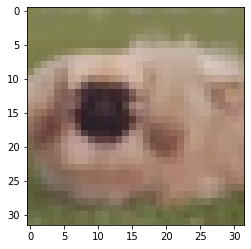

In [20]:
it = iter(loader_test)
sample_inputs, _ = next(it)

for i in range(32):
    fixed_input = sample_inputs[i, :, :, :]
    img = denorm(fixed_input)
    show(img)
    plt.savefig("test" + str(i) + ".pdf")


# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)

show(img)
plt.savefig("test.pdf")

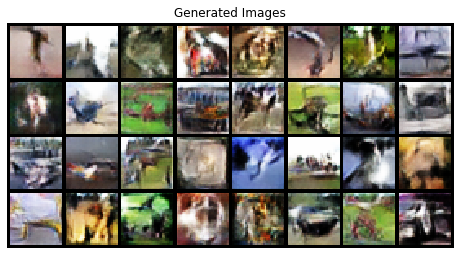

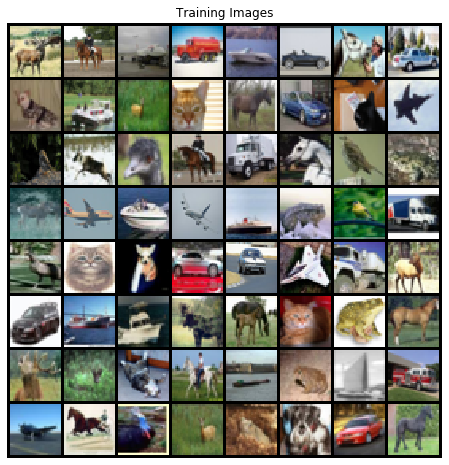

In [21]:
import torchvision.utils as vutils

# load the model
model_G.load_state_dict(torch.load('./DCGAN/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(vutils.make_grid(denorm(generated)[
               :32], padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.savefig("Generated images.png")
# show real images

# Plot some training images
real_batch = next(iter(loader_train))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[
           :64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.savefig("training images.png")
# Plot some training images

### Train losses curves

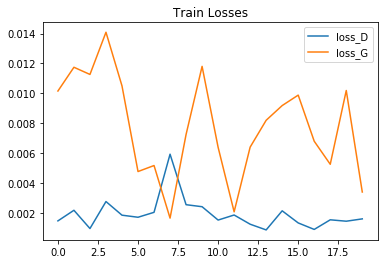

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
plt.plot(list(range(0, np.array(train_losses_D).shape[0])), np.array(
    train_losses_D), label='loss_D')
plt.plot(list(range(0, np.array(train_losses_G).shape[0])), np.array(
    train_losses_G), label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()
plt.savefig("loss_curve.png")


It can be seen from the plot that training was not particularly stable, due to the large fluctuations in loss for both the descriminator and generator. 

There is, however, a general downward trend of the generator loss. This is theoretically sensible, as the generator should be getting better at generating images that fool the discriminator. As it gets better, it's loss decreases.

The descriminator loss, however, remains relatively constant. This implies that the descriminator's weights are not being updated as quickly as the generator - and perhaps that the discriminator is being undertrained. This behaviour could be changed by pre-training the discriminator on real images for a period, before introducing the generator into the model.

### Mode collapse

Mode collapse is when the GAN only learns a small part of the distribution. Most data distributions are multi-modal in real life, so the result of mode collapse is to only represent a small number (or even none) of those modes. This manifests in the network generating images that all look the same (i.e from a single mode of the distribution). 

On observing my generated images from fixed noise, I would expect to see a grid of very similar looking images (as regardless of the input noise, it would always be mapped to an image from a single mode) if there was mode collapse. The images generated by my network, however, are varied and do not all look the same. Although there is certainly variation in the images, there are also noticeable similarities between images - particularly most of the images resemble animals or natural scenes. This is not very surprising given the CIFAR-10 dataset contains alot of pictures of animals, but there is certainly a dominance in my generated images. This would imply partial mode collapse, where animal classes dominate.

Mode collapse can often be attributed to too large a learning rate. The generator will generate images with which to fool the discriminator. If the discriminator is not updated sufficiently often, the generator will learn to generate images with modes (features) which are best at fooling the discriminator at that particular moment. The generator therefore focusses on these modes, and generates an imbalance of modes in training. The discriminator's performance subsequently degrades for other modes. This causes a kind of over-fitting to certain modes during training and results in mode collapse. Mode collapse can thus be targeted by fine-tuning the learning rate. More sophisticated tricks, like the Unrolled GAN could be used to mitigate mode collapse.

